<h1> DSCI 100 Project <\h1>

*Predicting news article popularity*
Group 28: Natsumi Tadakuma, Jackie Huang, Cindy Chen, Nikko Dumrique

### Introduction
In this proposal, we aim to predict the popularity based on News Popularity Data Set from https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity. The dataset summarizes statistical features about articles published on Mashable in a period of two years. Although the data set’s primary concern is predicting popularity, there is no inherent categorical variable to measure it. Therefore, for our analysis we will define the popularity of a news article based on the number of shares it has. We have created 4 categories of which define a range of shares; Not popular, somewhat popular, popular, and viral. 

#### Preliminary Exploratory data analysis

Predictive Question: Can we predict the popularity (# number of shares) given ... (predictor of the data)

In [37]:
library(tidyr)
library(repr)
library(rsample)
library(GGally)
library(ggplot2)
library(tidyverse)
library(tidymodels)

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ tune      0.1.1 
✔ infer     0.5.4      ✔ workflows 0.2.0 
✔ modeldata 0.0.2      ✔ yardstick 0.0.7 
✔ parsnip   0.1.3      

Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”
── Conflicts ──────────────────────

In [79]:
theme_set(
    theme_classic(base_size = 16)
)

The data we are trying to extract is in zip format. To extract the actual csv file from the web, we need to create a temporary file for the zip file, then unzip the file locally to read. On top of this, since the zip file also contains a .names file, we need to specify what we want to read when doing read_csv.

In [2]:
#download the zip file into a temporary file
temp <- tempfile()
temp_dir <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip", temp, mode="wb")
OnlineNewsPopularity_unzipped <- unzip(temp, exdir = temp_dir)

#read the csv within the unzipped_contents
news <- OnlineNewsPopularity_unzipped[2] %>% #may be unzipped_contents[1] if you get an error
    read_csv()
head(news)
unlink(c(temp, temp_dir))

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,⋯,0.10000000,0.7,-0.3500000,-0.600,-0.2000000,0.5000000,-0.1875000,0.00000000,0.1875000,593
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,⋯,0.03333333,0.7,-0.1187500,-0.125,-0.1000000,0.0000000,0.0000000,0.50000000,0.0000000,711
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731,9,211,0.5751295,1,0.6638655,3,1,1,⋯,0.10000000,1.0,-0.4666667,-0.800,-0.1333333,0.0000000,0.0000000,0.50000000,0.0000000,1500
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,731,9,531,0.5037879,1,0.6656347,9,0,1,⋯,0.13636364,0.8,-0.3696970,-0.600,-0.1666667,0.0000000,0.0000000,0.50000000,0.0000000,1200
http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.4156456,1,0.5408895,19,19,20,⋯,0.03333333,1.0,-0.2201923,-0.500,-0.0500000,0.4545455,0.1363636,0.04545455,0.1363636,505
http://mashable.com/2013/01/07/beewi-smart-toys/,731,10,370,0.5598886,1,0.6981982,2,2,0,⋯,0.13636364,0.6,-0.1950000,-0.400,-0.1000000,0.6428571,0.2142857,0.14285714,0.2142857,855


## Wrangle and clean
Creating a categorical variable to represent the popularity (shares) so it help us better visualize the data. The dividing criteria comes from the summary of the shares

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1     933    1400    2935    2600  690400 

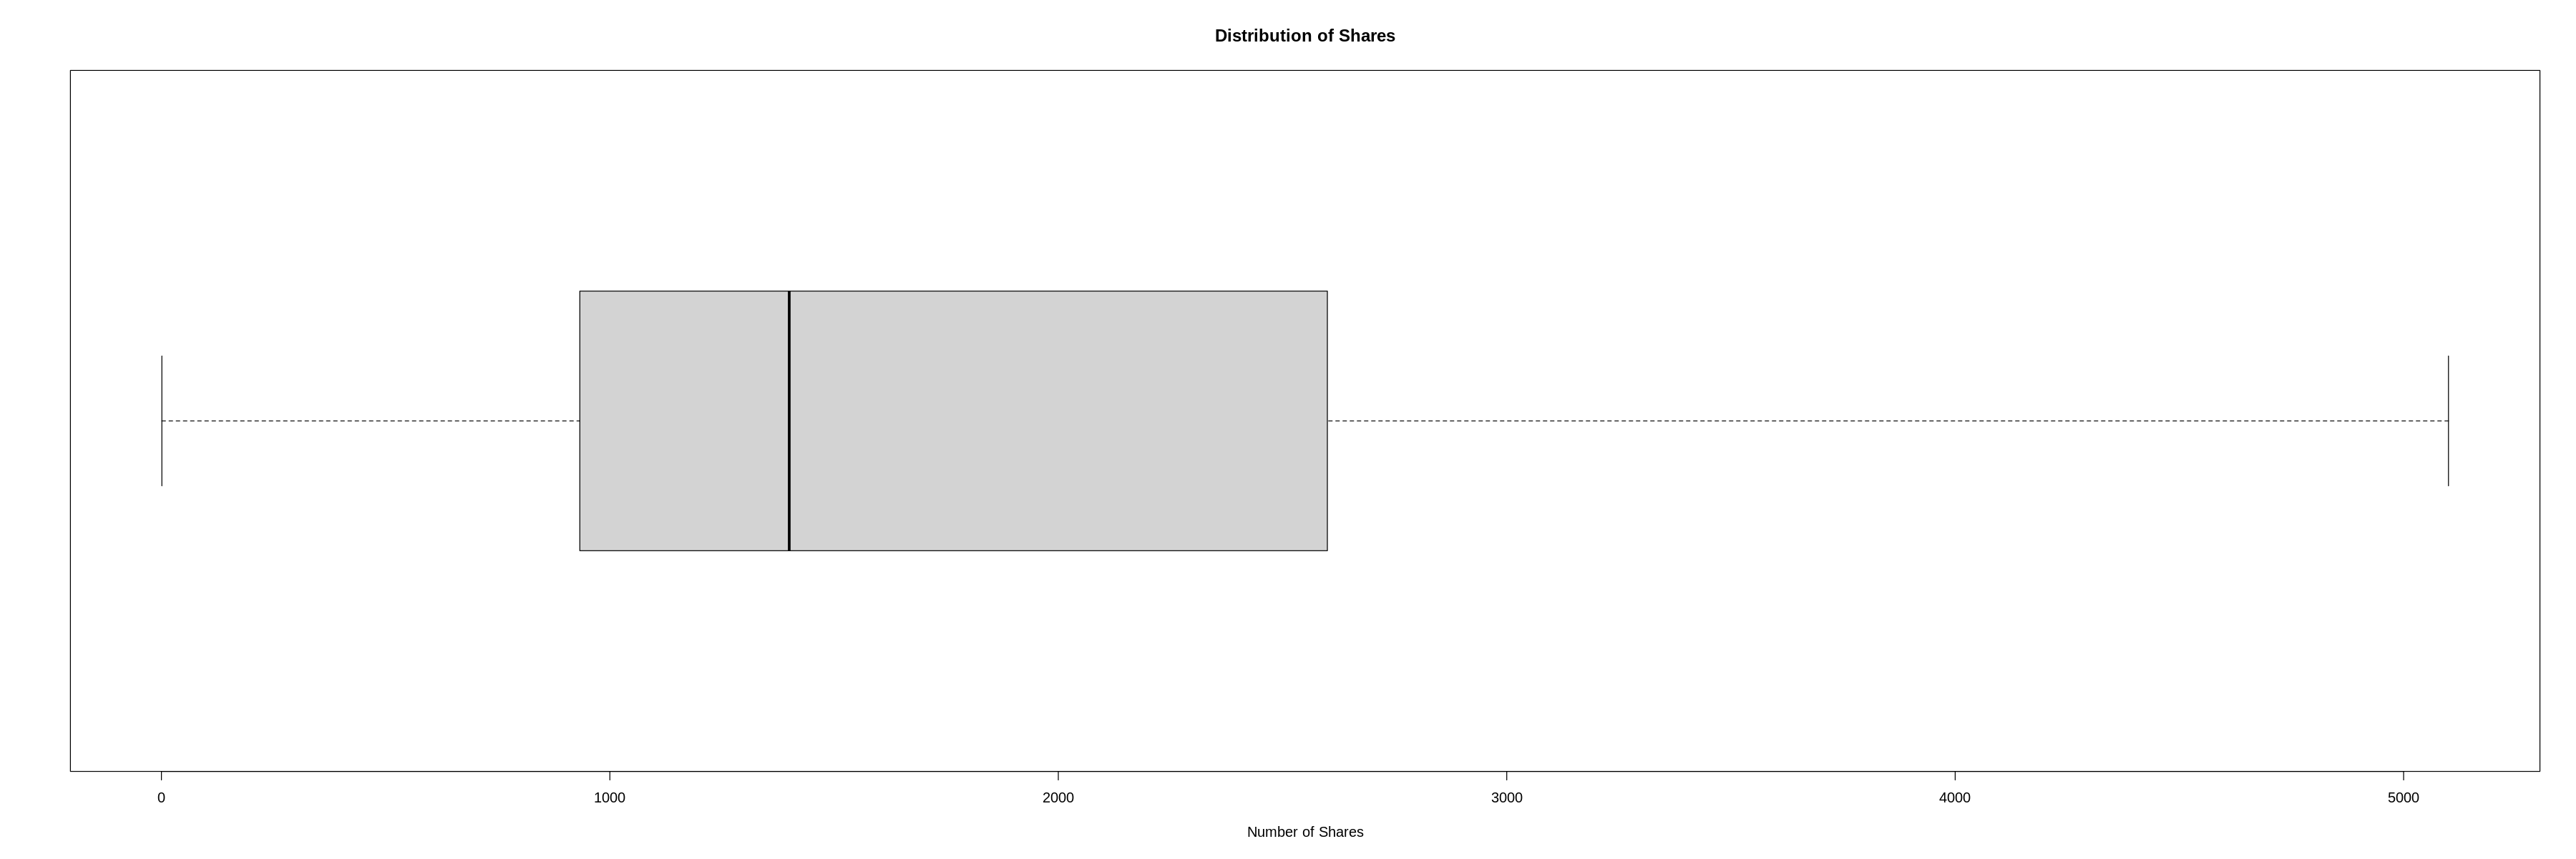

In [82]:
options(repr.plot.width = 30, repr.plot.height = 10)
summary(news$shares)
boxplot(news$shares, outline = FALSE, horizontal = TRUE)
title(main = "Distribution of Shares", xlab = "Number of Shares")

summary on the number of shares:

In [4]:
news = news %>% 
      mutate(popularity = ifelse(shares < 500, "Not_Popular",
                          ifelse(shares %in% 500:1399, "Somewhat_Popular",
                          ifelse(shares %in% 1400:3299, "Popular", "Viral")))) %>% 
      mutate(popularity = as.factor(popularity))

In [5]:
# combining the weekdays and data channels into one column
# We set all 0 to NA here, because in the original data set, 0 is used to represent FALSE. 
# Therefore, to get rid of all FALSE values, we set them to NA so that in pivot_longer, 
# we can remove these unecessary data points using value_drop_na = TRUE
news[,14:19][news[,14:19] == 0] = NA
news = news %>% 
    pivot_longer(data_channel_is_lifestyle:data_channel_is_world,
                 names_to = "Channel",
                 names_prefix = "data_channel_is_",
                 values_to = "Value",
                 values_drop_na = TRUE) %>% 
  select(-Value)
# Same thing here, setting 0 values to NA to get rid of them
news[,32:38][news[32:38] == 0] = NA
news = news %>% 
    pivot_longer(weekday_is_monday:weekday_is_sunday,
                 names_to = "weekday",
                 names_prefix = "weekday_is_",
                 values_to = "value",
                 values_drop_na = TRUE) %>% 
  select(-value)
head(news$weekday, 21)

[1] "monday"    "tuesday"   "wednesday" "thursday"  "friday"    "saturday" 
 [7] "monday"    "tuesday"   "wednesday" "thursday"  "friday"    "saturday" 
[13] "monday"    "tuesday"   "wednesday" "thursday"  "friday"    "saturday" 
[19] "monday"    "tuesday"   "wednesday"

### Exploratory Data analysis

By ref

In [6]:
splitted_data <- initial_split(news, prop = 0.80, strata = popularity)  
training_set <- training(splitted_data)   
testing_set <- testing(splitted_data)
# training_set
# testing_set
# https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio

In [7]:
## To filter out only quantitative varibles
news_numerical = unlist(lapply(training_set, is.numeric)) 
news_numerical = training_set[ , news_numerical]
cor(news_numerical) %>%
  as_data_frame(rownames = "var1") %>%
    pivot_longer(cols = -var1, names_to = "var2", values_to = "coeff") %>%
    filter(var1 == "shares") %>% 
    filter(var1 != var2) %>%
    arrange(desc(abs(coeff)))
## Code reference:
## https://stackoverflow.com/questions/48123611/using-ggpairs-on-a-large-dataset-with-many-variables

Warning message:
“`as_data_frame()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


var1,var2,coeff
<chr>,<chr>,<dbl>
shares,kw_avg_avg,0.0963031056
shares,kw_max_avg,0.0615419087
shares,self_reference_avg_sharess,0.0572510168
shares,self_reference_min_shares,0.0525813924
shares,self_reference_max_shares,0.0466063386
shares,num_hrefs,0.0426926437
shares,kw_max_min,0.0374186949
shares,kw_avg_min,0.0372368662
shares,global_subjectivity,0.0347989530


Based on the above, we choose kw_avg_avg, self_reference_avg_sharess, and num_hrefs.
That is, the Average keyword (avg. shares), the Avg. shares of referenced articles in Mashable, and the Number of links as they have the highest correlation with shares.



By filtering out the missing values, we successfully increased the correlation for 0.001 for the self_reference_avg_sharess predictor. That is evidence of something worked

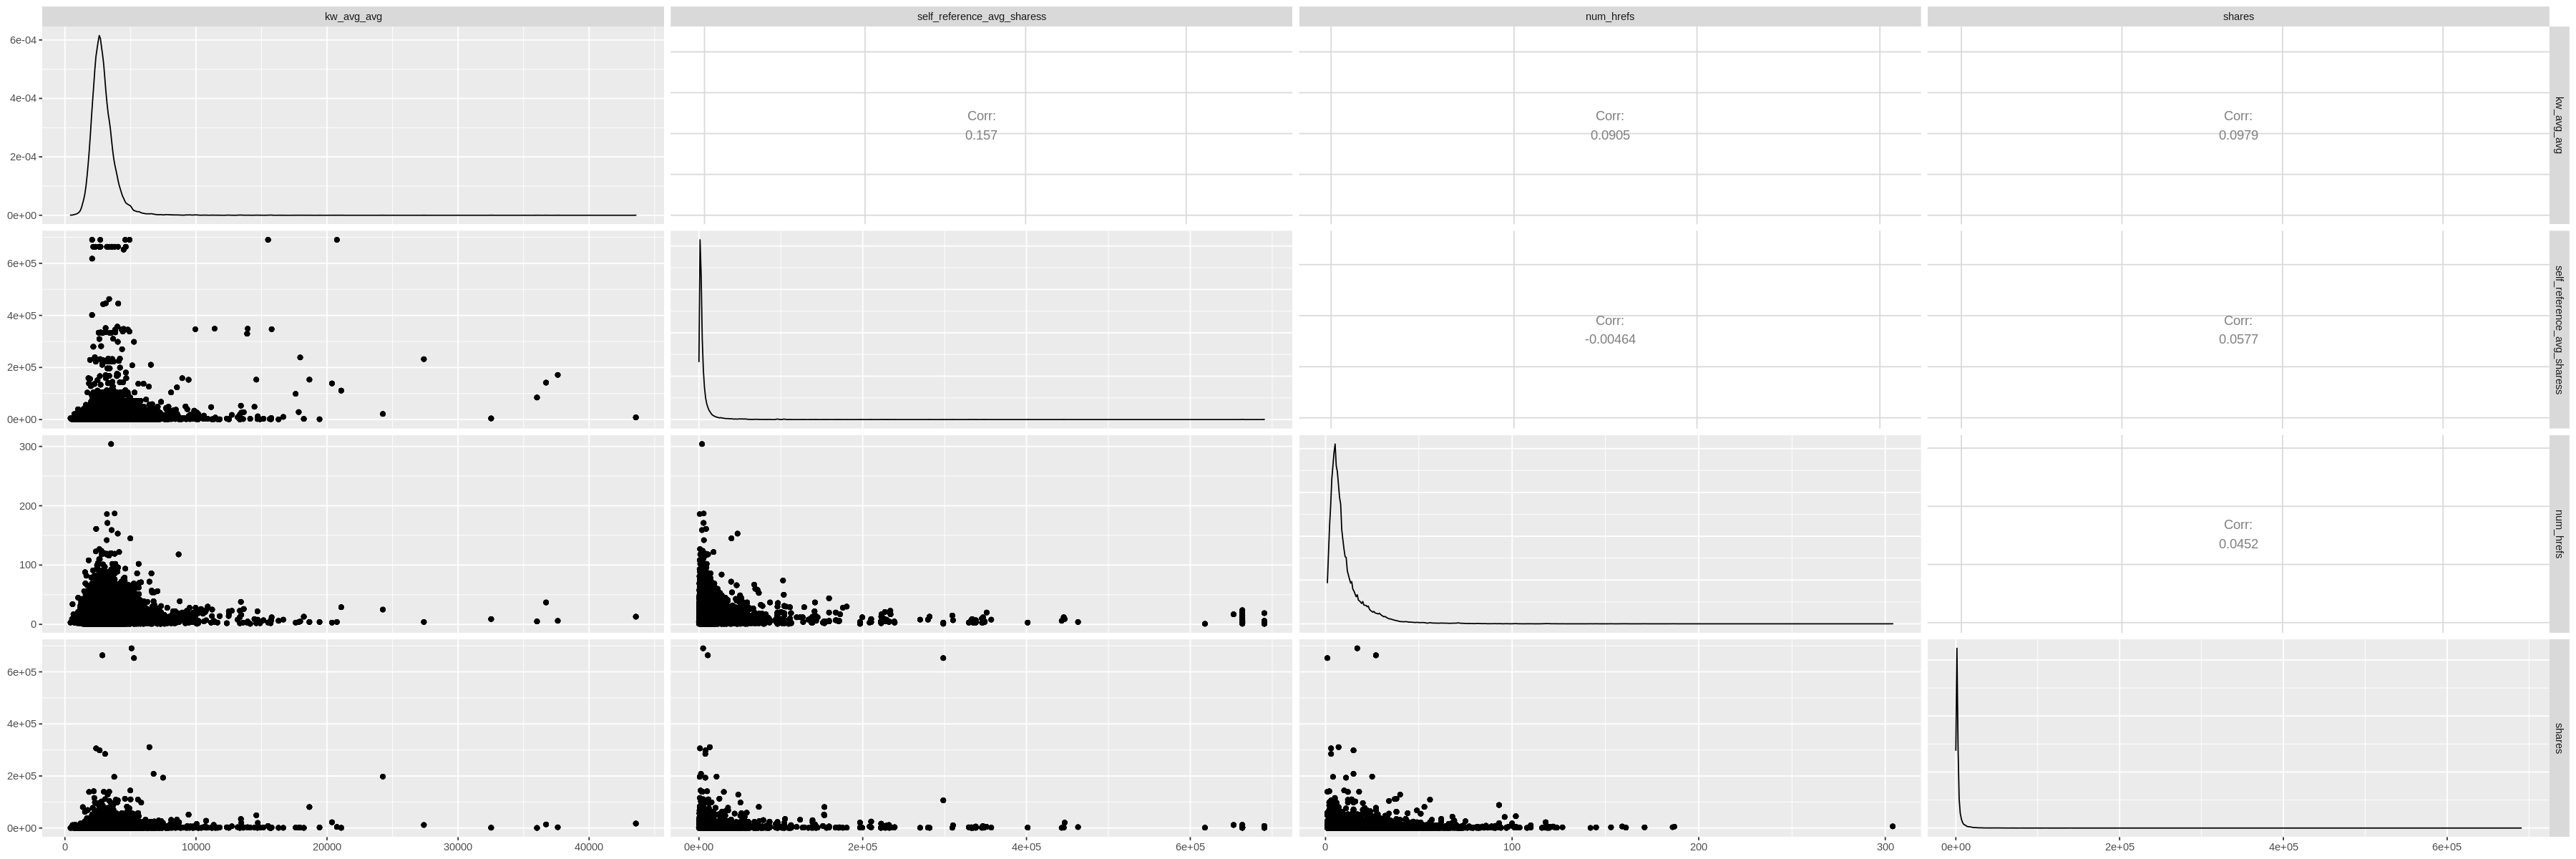

In [8]:
training_set %>% select(kw_avg_avg, self_reference_avg_sharess, num_hrefs, shares) %>% 
                  filter(kw_avg_avg != 0) %>% 
                  filter(self_reference_avg_sharess != 0) %>% 
                  filter(num_hrefs != 0) %>% 
                   ggpairs()

In [28]:
tran_predictors = training_set %>% select(kw_avg_avg, self_reference_avg_sharess, 
                                          num_hrefs, shares, popularity)
head(tran_predictors)

kw_avg_avg,self_reference_avg_sharess,num_hrefs,shares,popularity
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,496,4,593,Somewhat_Popular
0,496,4,593,Somewhat_Popular
0,496,4,593,Somewhat_Popular
0,496,4,593,Somewhat_Popular
0,0,3,711,Somewhat_Popular
0,0,3,711,Somewhat_Popular


Observing the dataset, we notice that some obervations have 0 as an value, we treat them as missing values as 0 will not do any good to our predictions. So we further process our training data

   kw_avg_avg    self_reference_avg_sharess   num_hrefs          shares      
 Min.   :    0   Min.   :     0             Min.   :  0.00   Min.   :     1  
 1st Qu.: 2314   1st Qu.:   954             1st Qu.:  4.00   1st Qu.:   934  
 Median : 2737   Median :  2100             Median :  7.00   Median :  1400  
 Mean   : 2891   Mean   :  5814             Mean   : 10.41   Mean   :  2938  
 3rd Qu.: 3273   3rd Qu.:  4650             3rd Qu.: 13.00   3rd Qu.:  2600  
 Max.   :43568   Max.   :690400             Max.   :304.00   Max.   :690400  

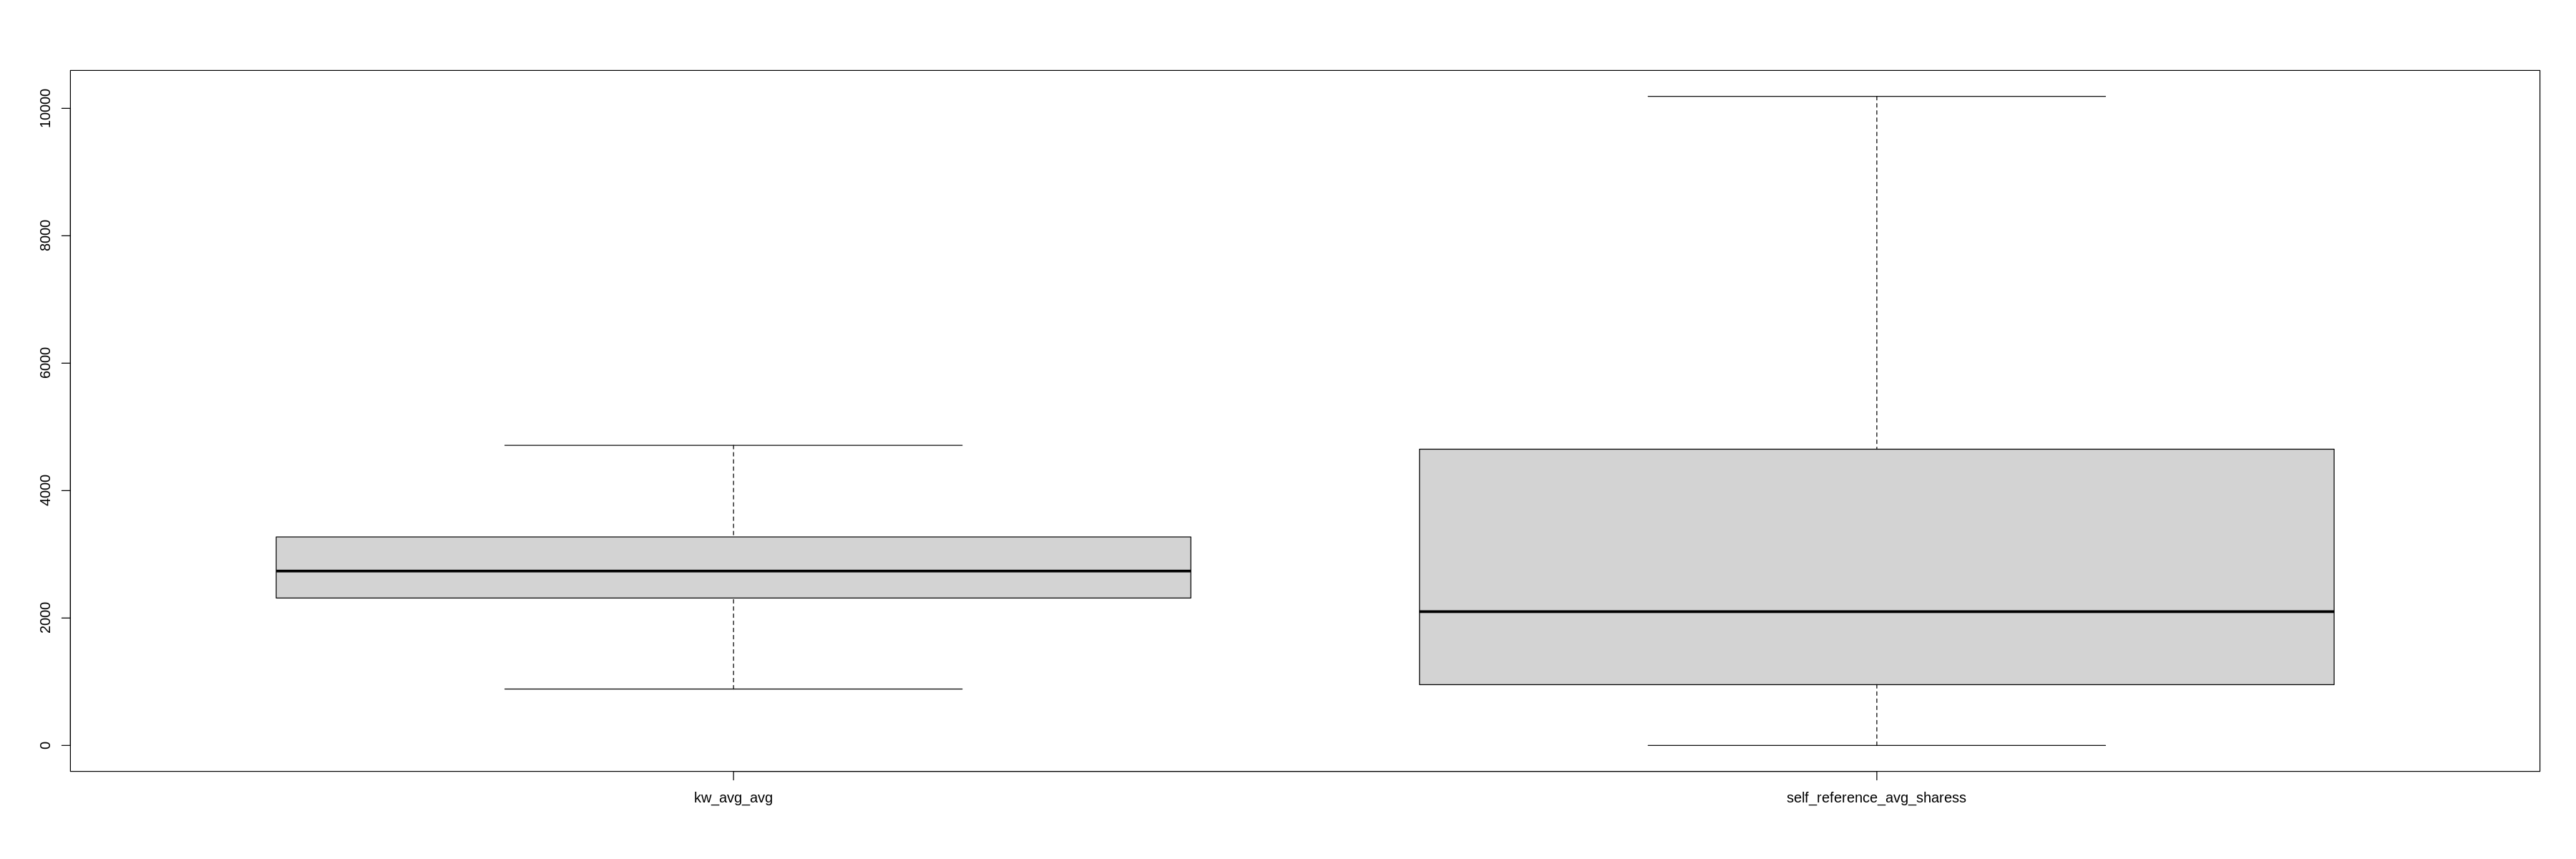

In [10]:
summary(tran_predictors %>% select(-popularity))
boxplot(tran_predictors %>% select(-popularity, -shares, -num_hrefs), outline = FALSE)

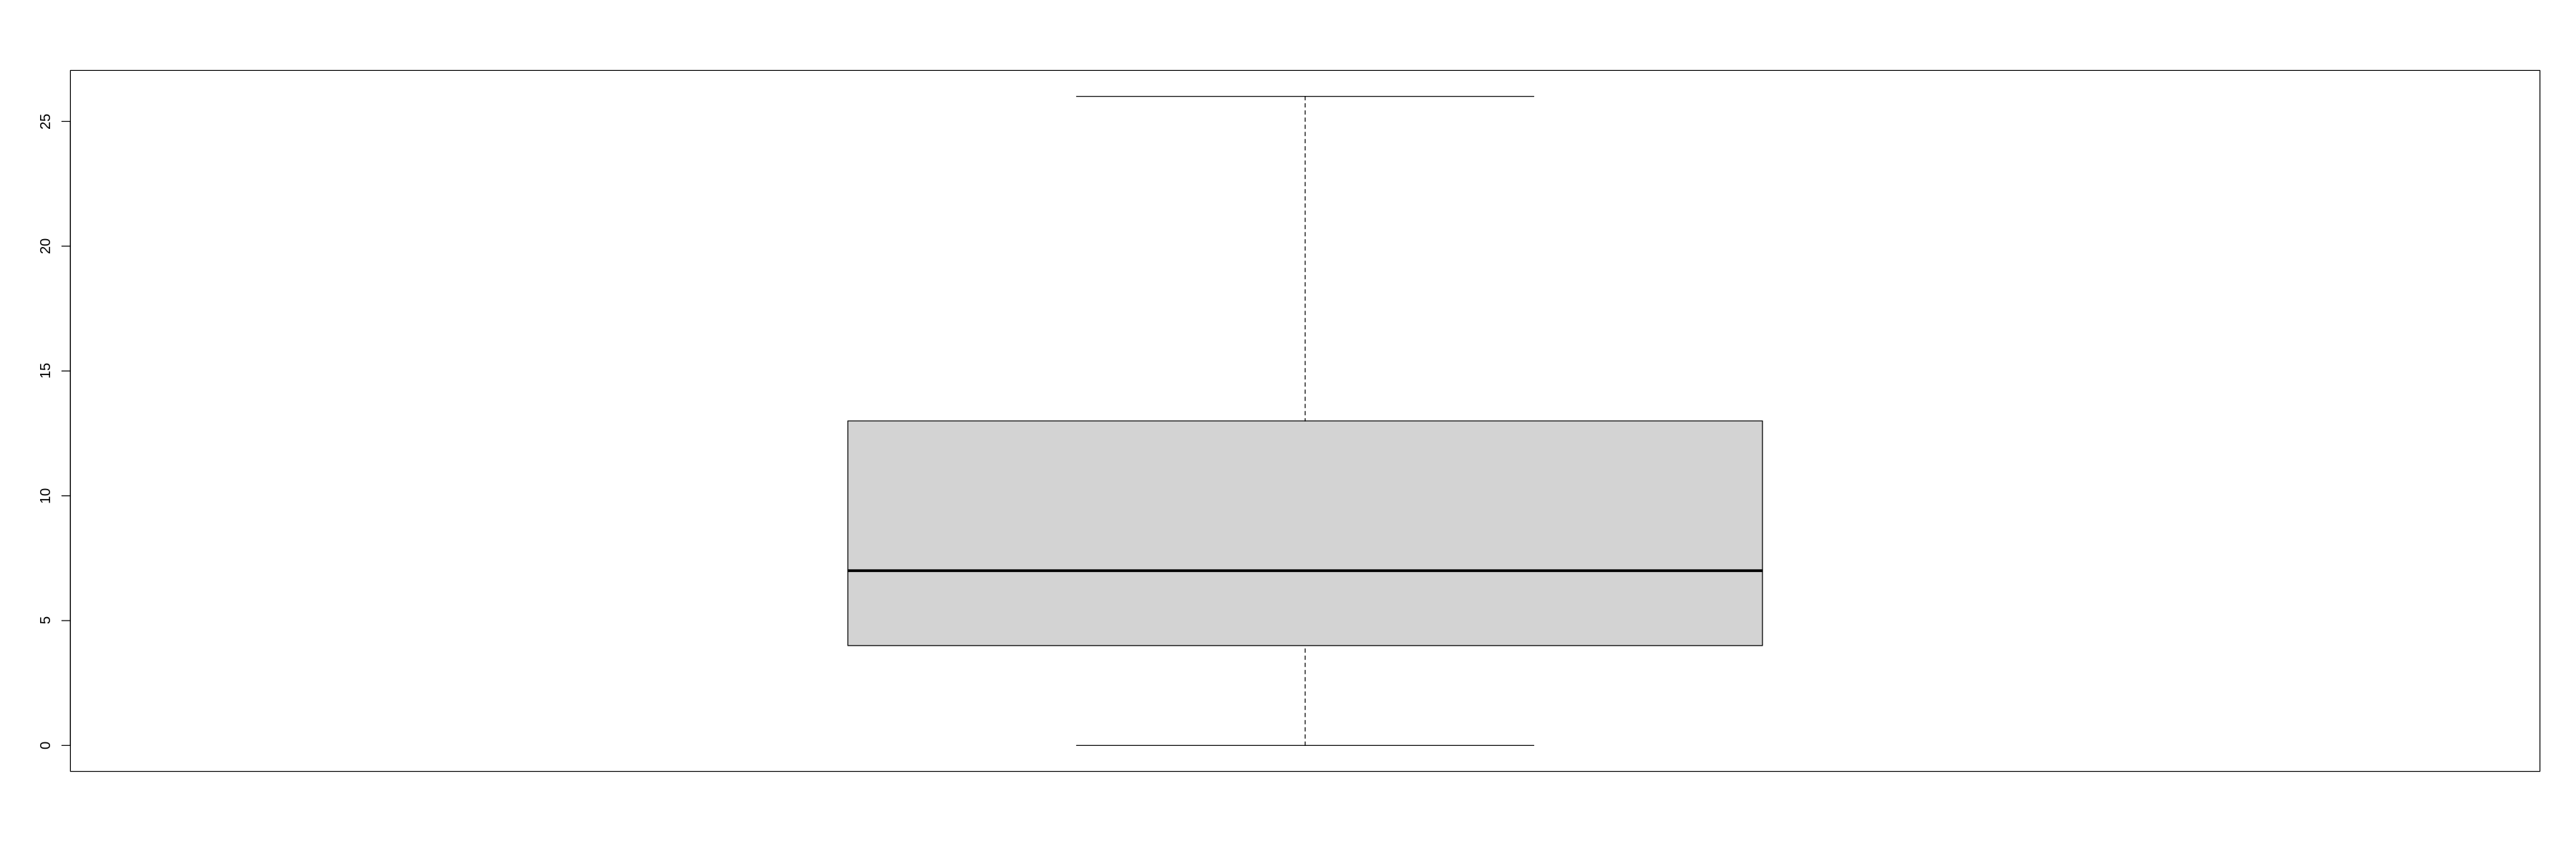

In [11]:
boxplot(tran_predictors$num_hrefs, outline = FALSE)

In [29]:
tran_predictors = tran_predictors %>% 
                  filter(kw_avg_avg != 0) %>% 
                  filter(self_reference_avg_sharess != 0) %>% 
                  filter(num_hrefs != 0)
head(tran_predictors)

kw_avg_avg,self_reference_avg_sharess,num_hrefs,shares,popularity
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
804.3803,3100,5,755,Somewhat_Popular
804.3803,3100,5,755,Somewhat_Popular
804.3803,3100,5,755,Somewhat_Popular
804.3803,3100,5,755,Somewhat_Popular
1184.5600,727,4,4600,Viral
1184.5600,727,4,4600,Viral


We noticed that there are duplicated rows in the tran_predictors, so we want to remove them her. The duplication is probabily caused by some categorical variables that is not selected in train_predictors

In [30]:
tran_predictors = tran_predictors %>% distinct()
head(tran_predictors)

kw_avg_avg,self_reference_avg_sharess,num_hrefs,shares,popularity
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
804.3803,3100.000,5,755,Somewhat_Popular
1184.5600,727.000,4,4600,Viral
1114.0240,951.000,5,1300,Somewhat_Popular
884.8520,1300.000,14,1200,Somewhat_Popular
1539.4172,3151.158,20,1500,Popular
713.9192,20900.000,3,1700,Popular


##### Visualize Explorary

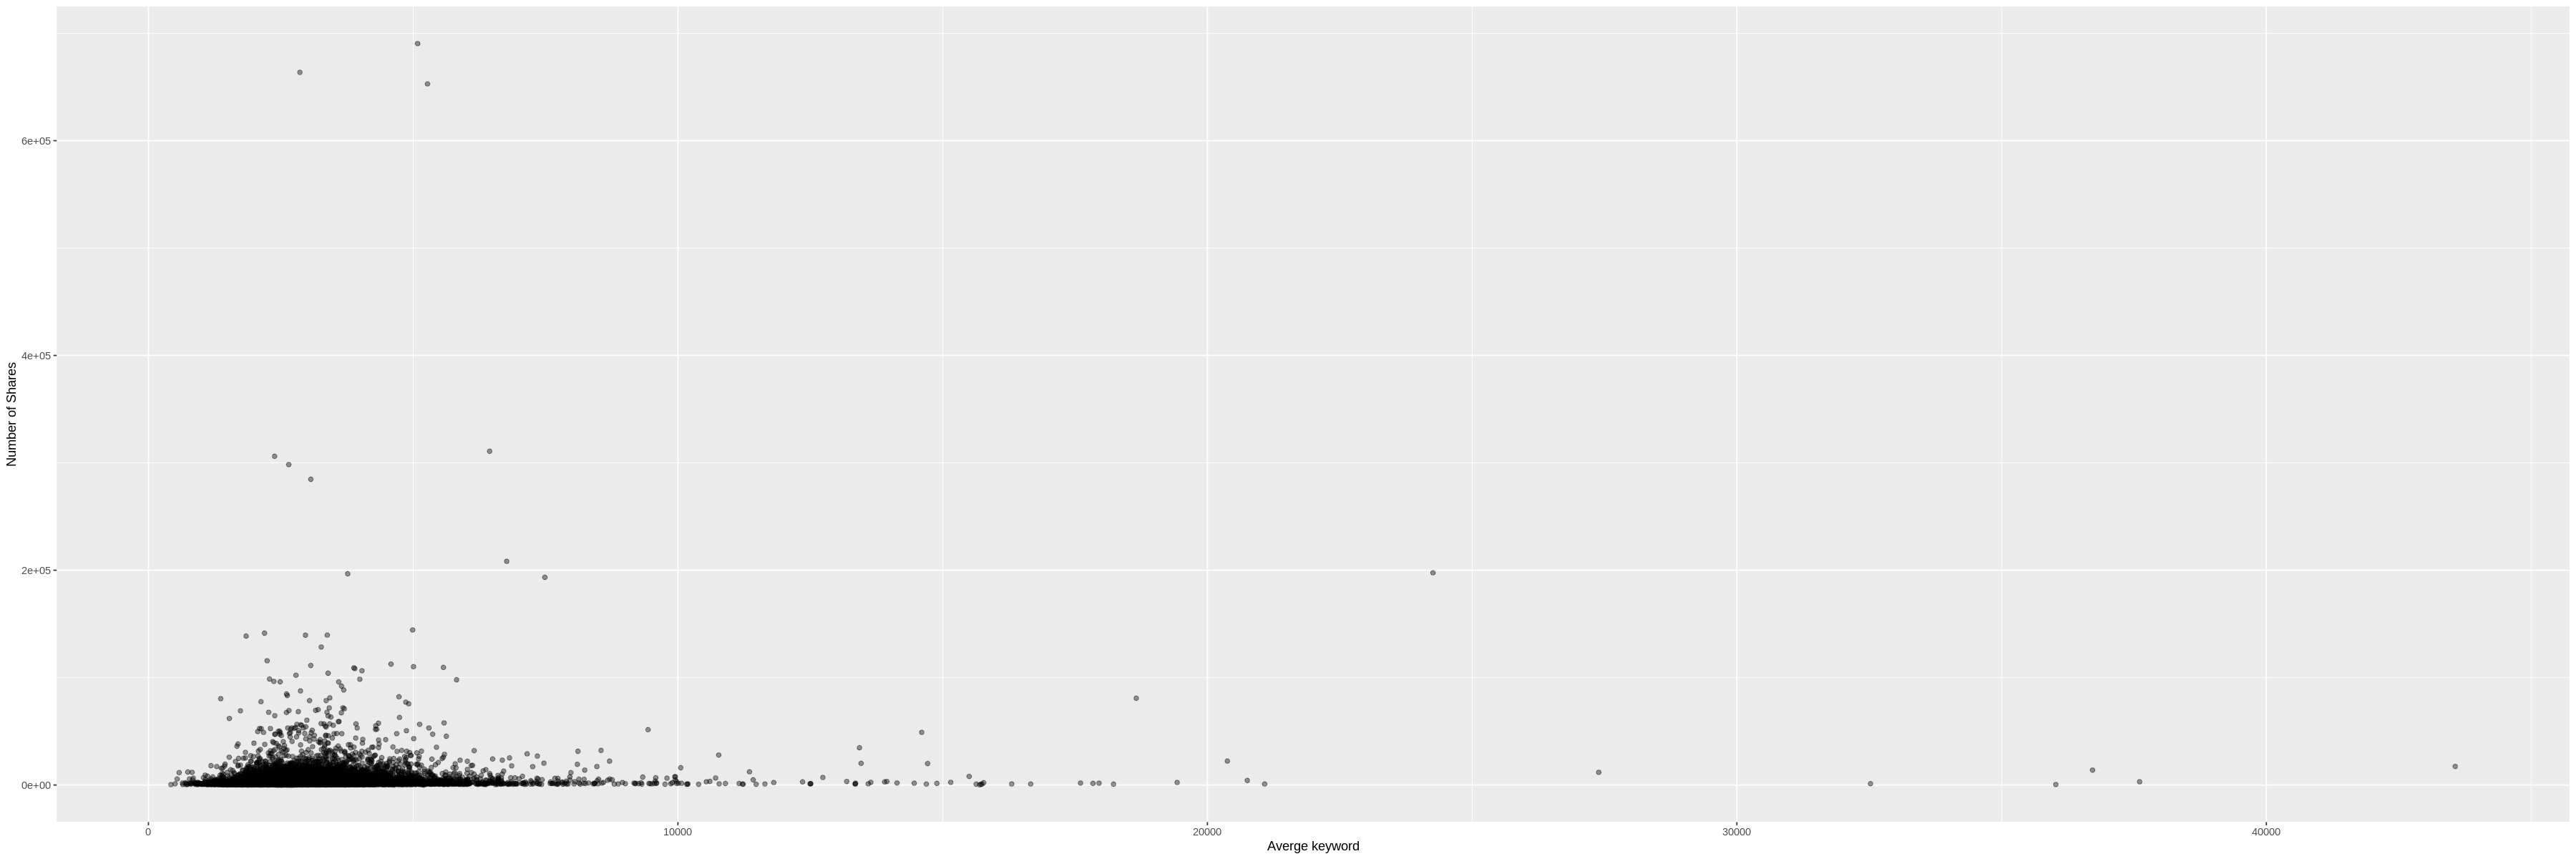

In [14]:
eda_kw_rm <- tran_predictors %>% 
                  ggplot(aes(x = kw_avg_avg, y = shares)) +
                  geom_point(alpha = 0.4) +
                  xlab("Averge keyword") +
                  ylab("Number of Shares")
eda_kw_rm

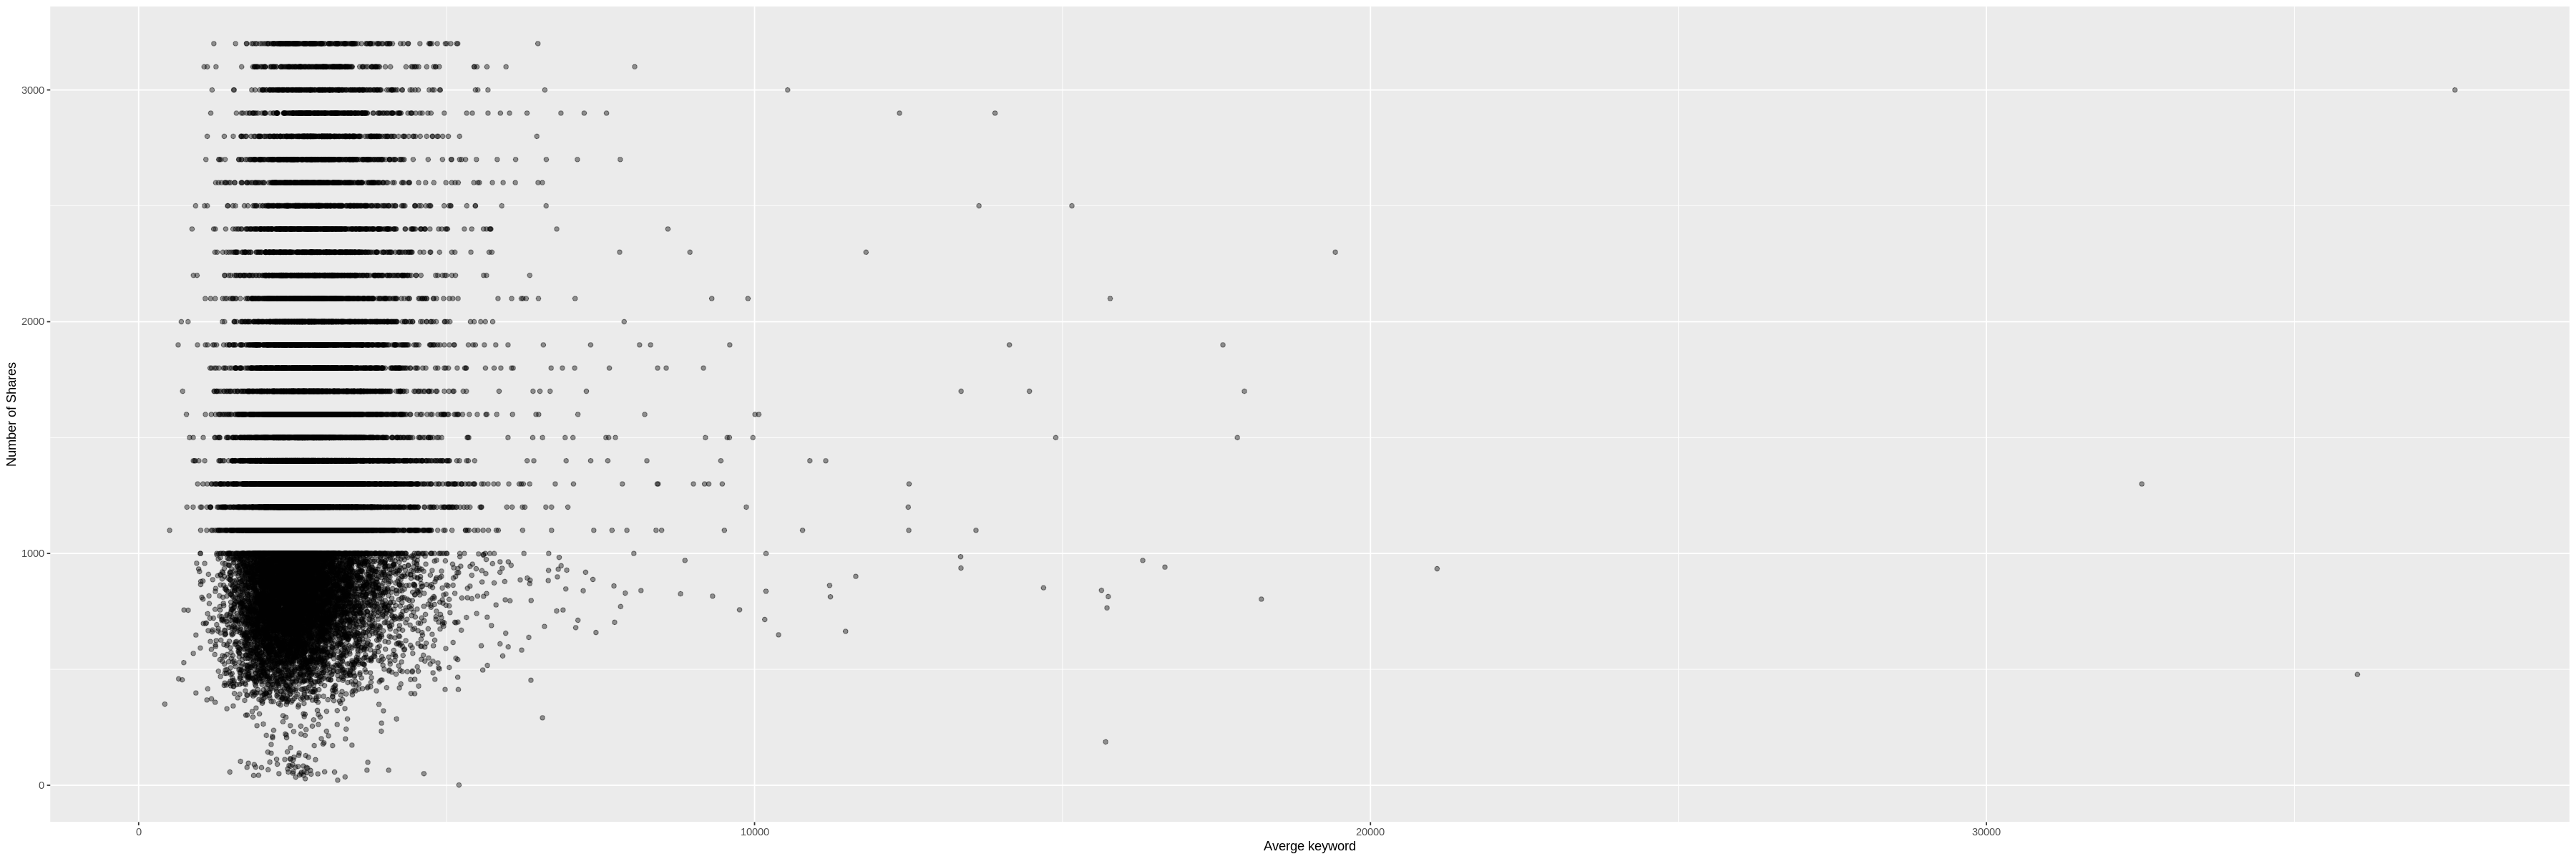

In [15]:
eda_kw_rm_outl <- tran_predictors %>% 
                  filter(popularity != "Viral") %>% 
                  # filter(kw_avg_avg < 10000) %>% 
                  ggplot(aes(x = kw_avg_avg, y = shares)) +
                  geom_point(alpha = 0.4) +
                  xlab("Averge keyword") +
                  ylab("Number of Shares")
eda_kw_rm_outl

 the correlation is small, so it is unlikely we will see a linear pattern

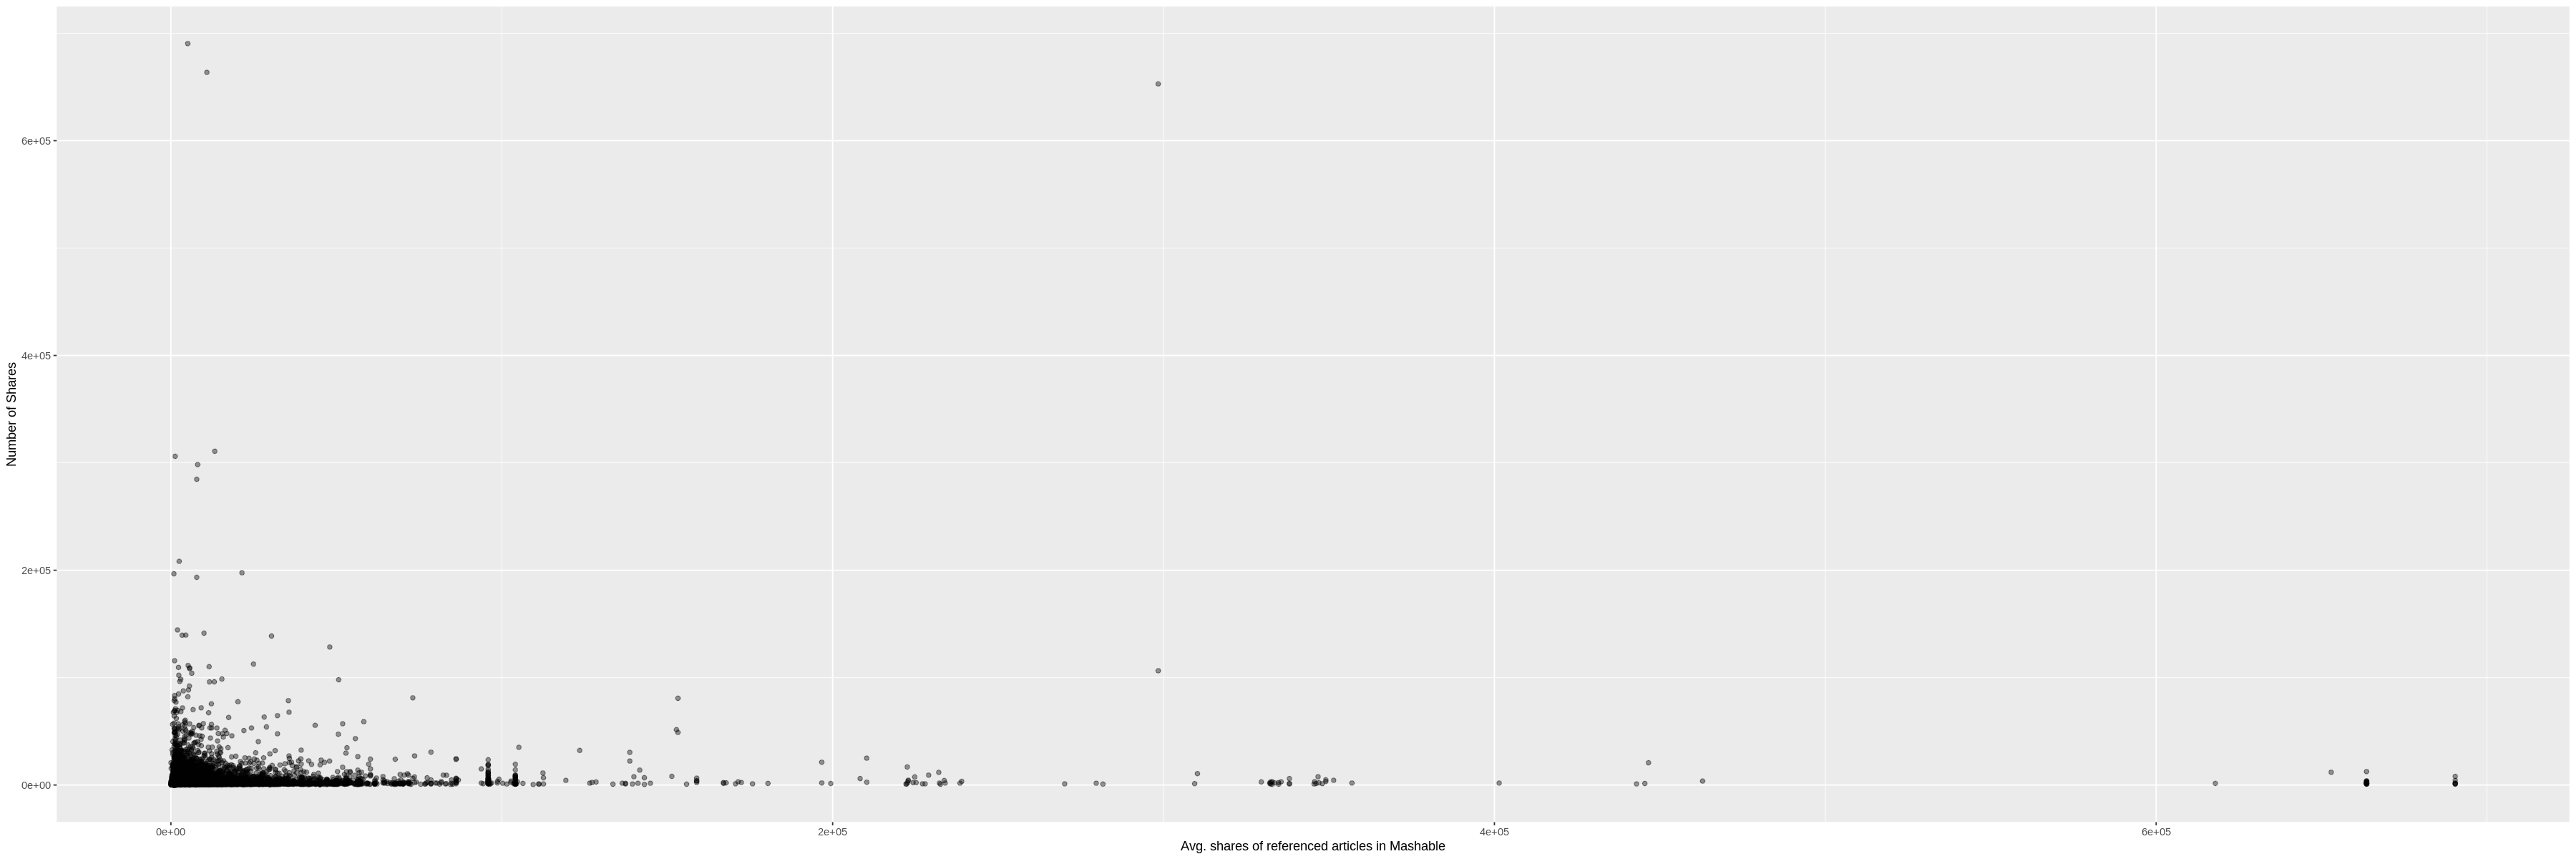

In [16]:
eda_sf_rm <- tran_predictors %>% 
                  ggplot(aes(x = self_reference_avg_sharess, y = shares)) +
                  geom_point(alpha = 0.4) +
                  xlab("Avg. shares of referenced articles in Mashable") +
                  ylab("Number of Shares")
eda_sf_rm

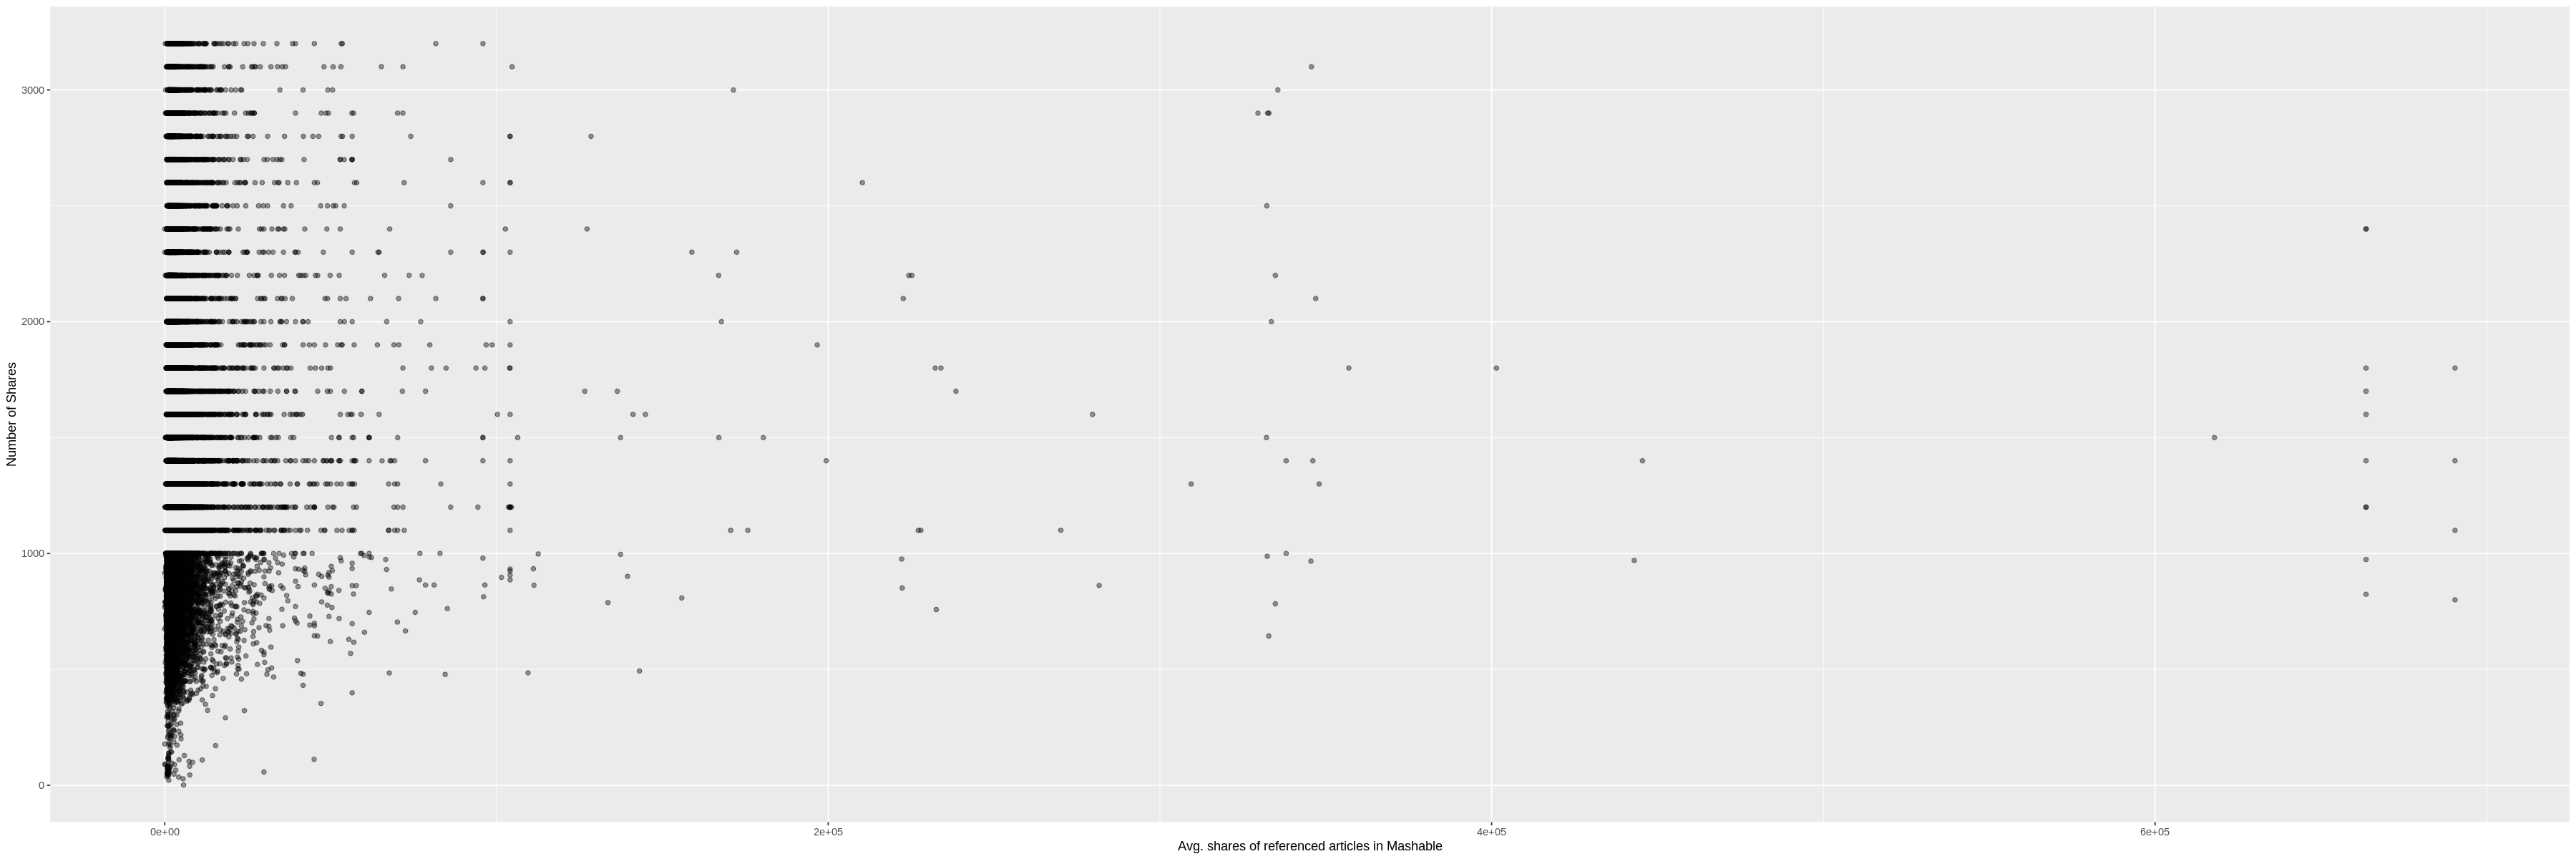

In [17]:
## Remove the outliers
eda_sf_rm_outl <- tran_predictors %>% 
                  filter(popularity != "Viral") %>%
                  # filter(self_reference_avg_sharess < 2e+05) %>%
                  ggplot(aes(x = self_reference_avg_sharess, y = shares)) +
                  geom_point(alpha = 0.4) +
                  xlab("Avg. shares of referenced articles in Mashable") +
                  ylab("Number of Shares")
eda_sf_rm_outl

 the correlation is small, so it is unlikely we will see a linear pattern

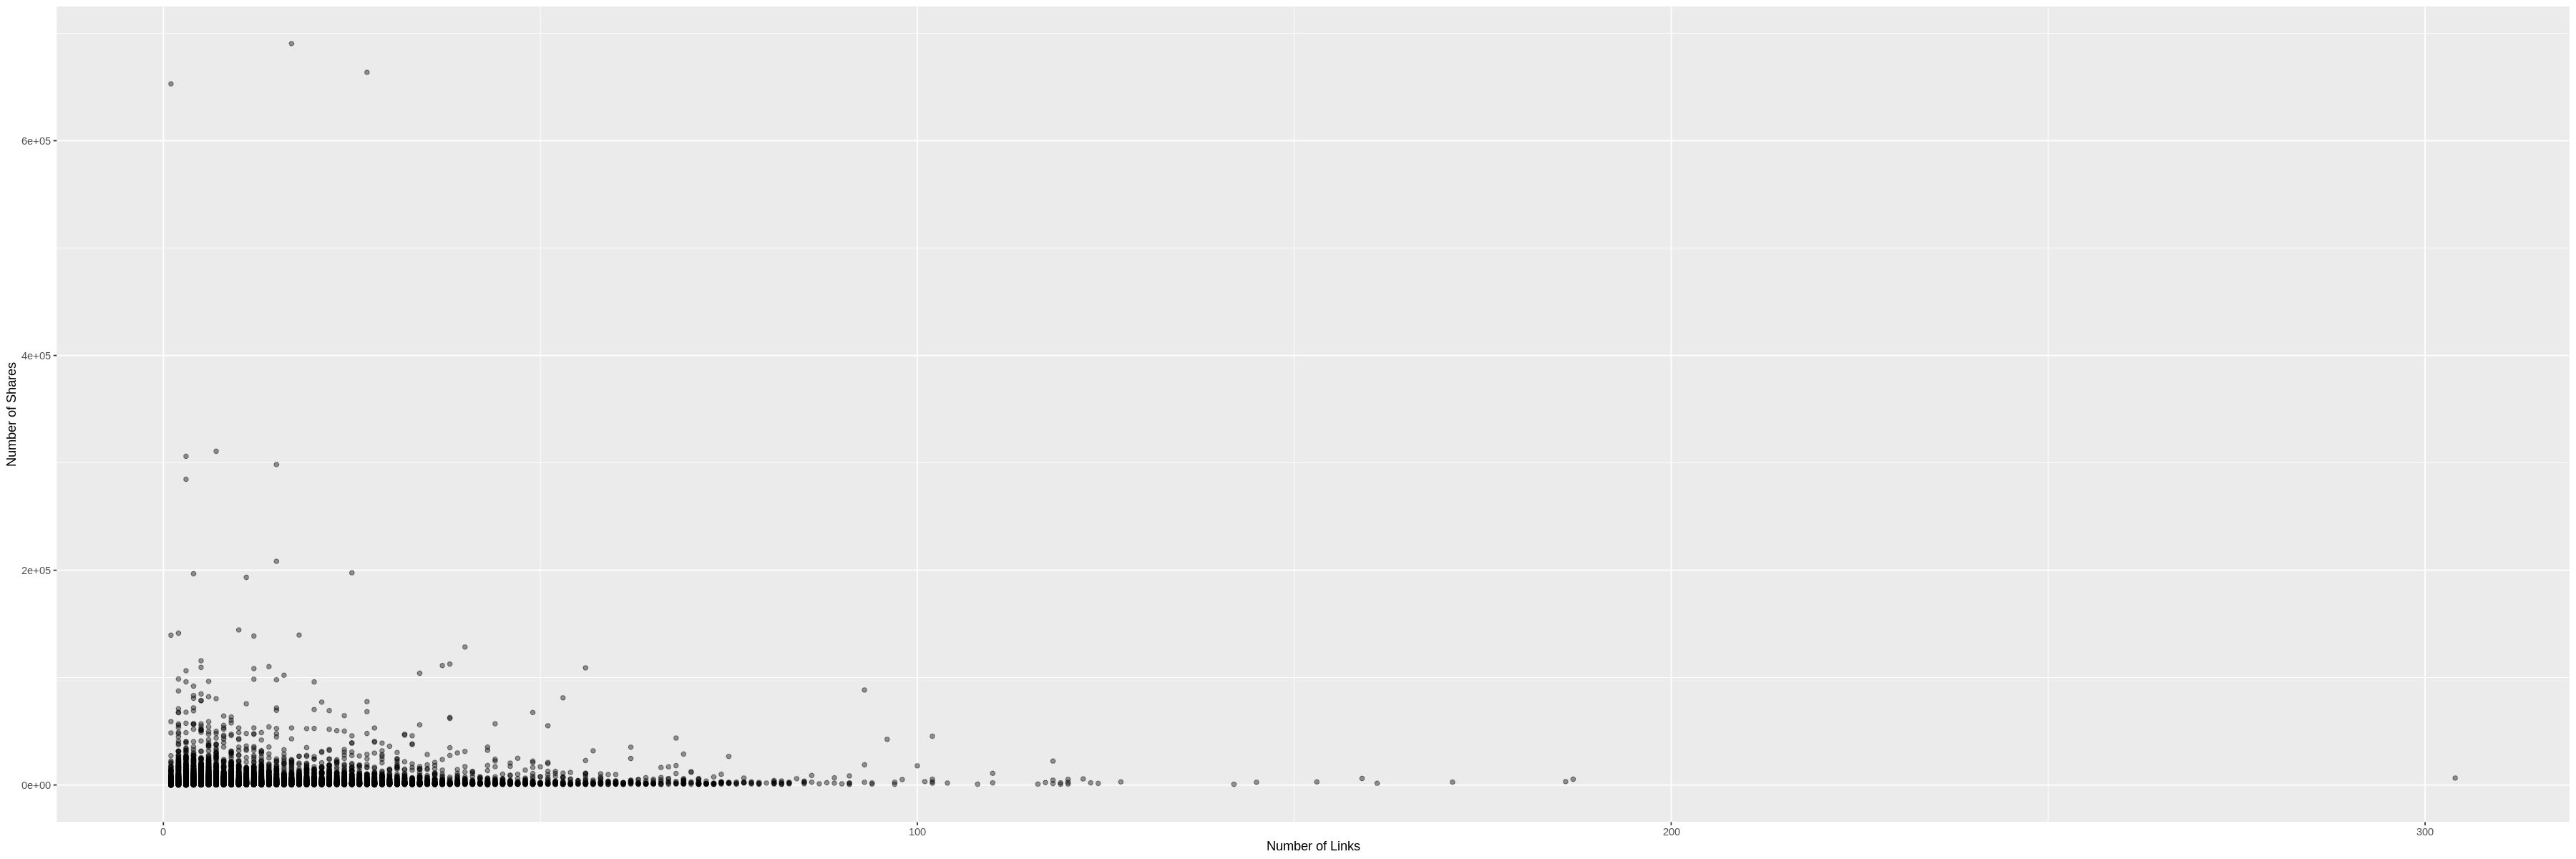

In [18]:
eda_ref_rm <- tran_predictors %>% 
                  ggplot(aes(x = num_hrefs, y = shares)) +
                  geom_point(alpha = 0.4) +
                  xlab("Number of Links") +
                  ylab("Number of Shares")
eda_ref_rm

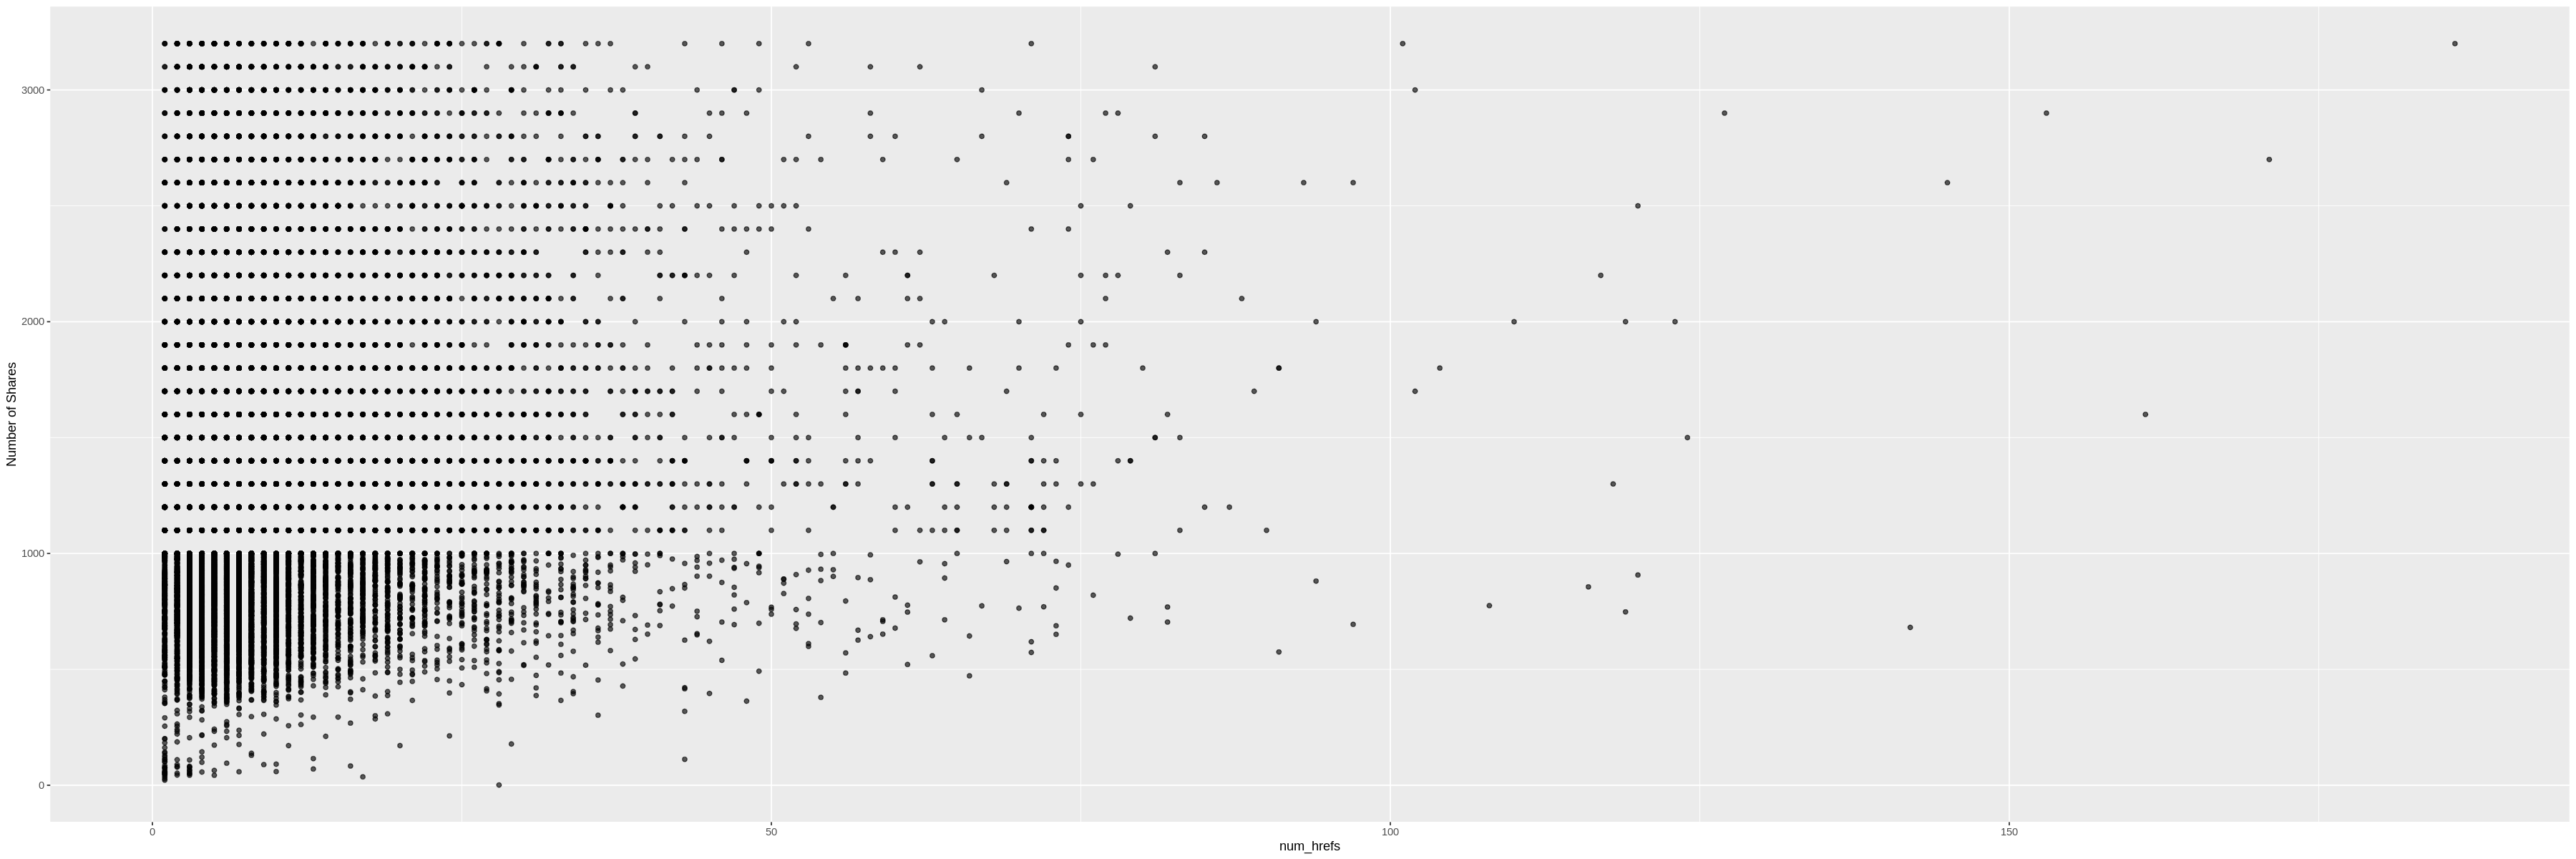

In [19]:
## Remove the outliers
eda_ref_rm_outl <- tran_predictors %>% 
                  filter(popularity != "Viral") %>%
                  # filter(self_reference_avg_sharess < 2e+05) %>%
                  ggplot(aes(x = num_hrefs, y = shares)) +
                  geom_point(alpha = 0.4) +
                  geom_point(alpha = 0.4) +
                  ylab("Number of Shares")
eda_ref_rm_outl

In [20]:
## the correlation is small, so it is unlikely we will see a linear pattern

A count of the observations in each popularity category

In [21]:
tran_predictors %>% group_by(popularity) %>% 
                    summarise(count = n())

`summarise()` ungrouping output (override with `.groups` argument)



popularity,count
<fct>,<int>
Not_Popular,609
Popular,9019
Somewhat_Popular,12595
Viral,5147


Warning message:
“Removed 303 rows containing non-finite values (stat_boxplot).”


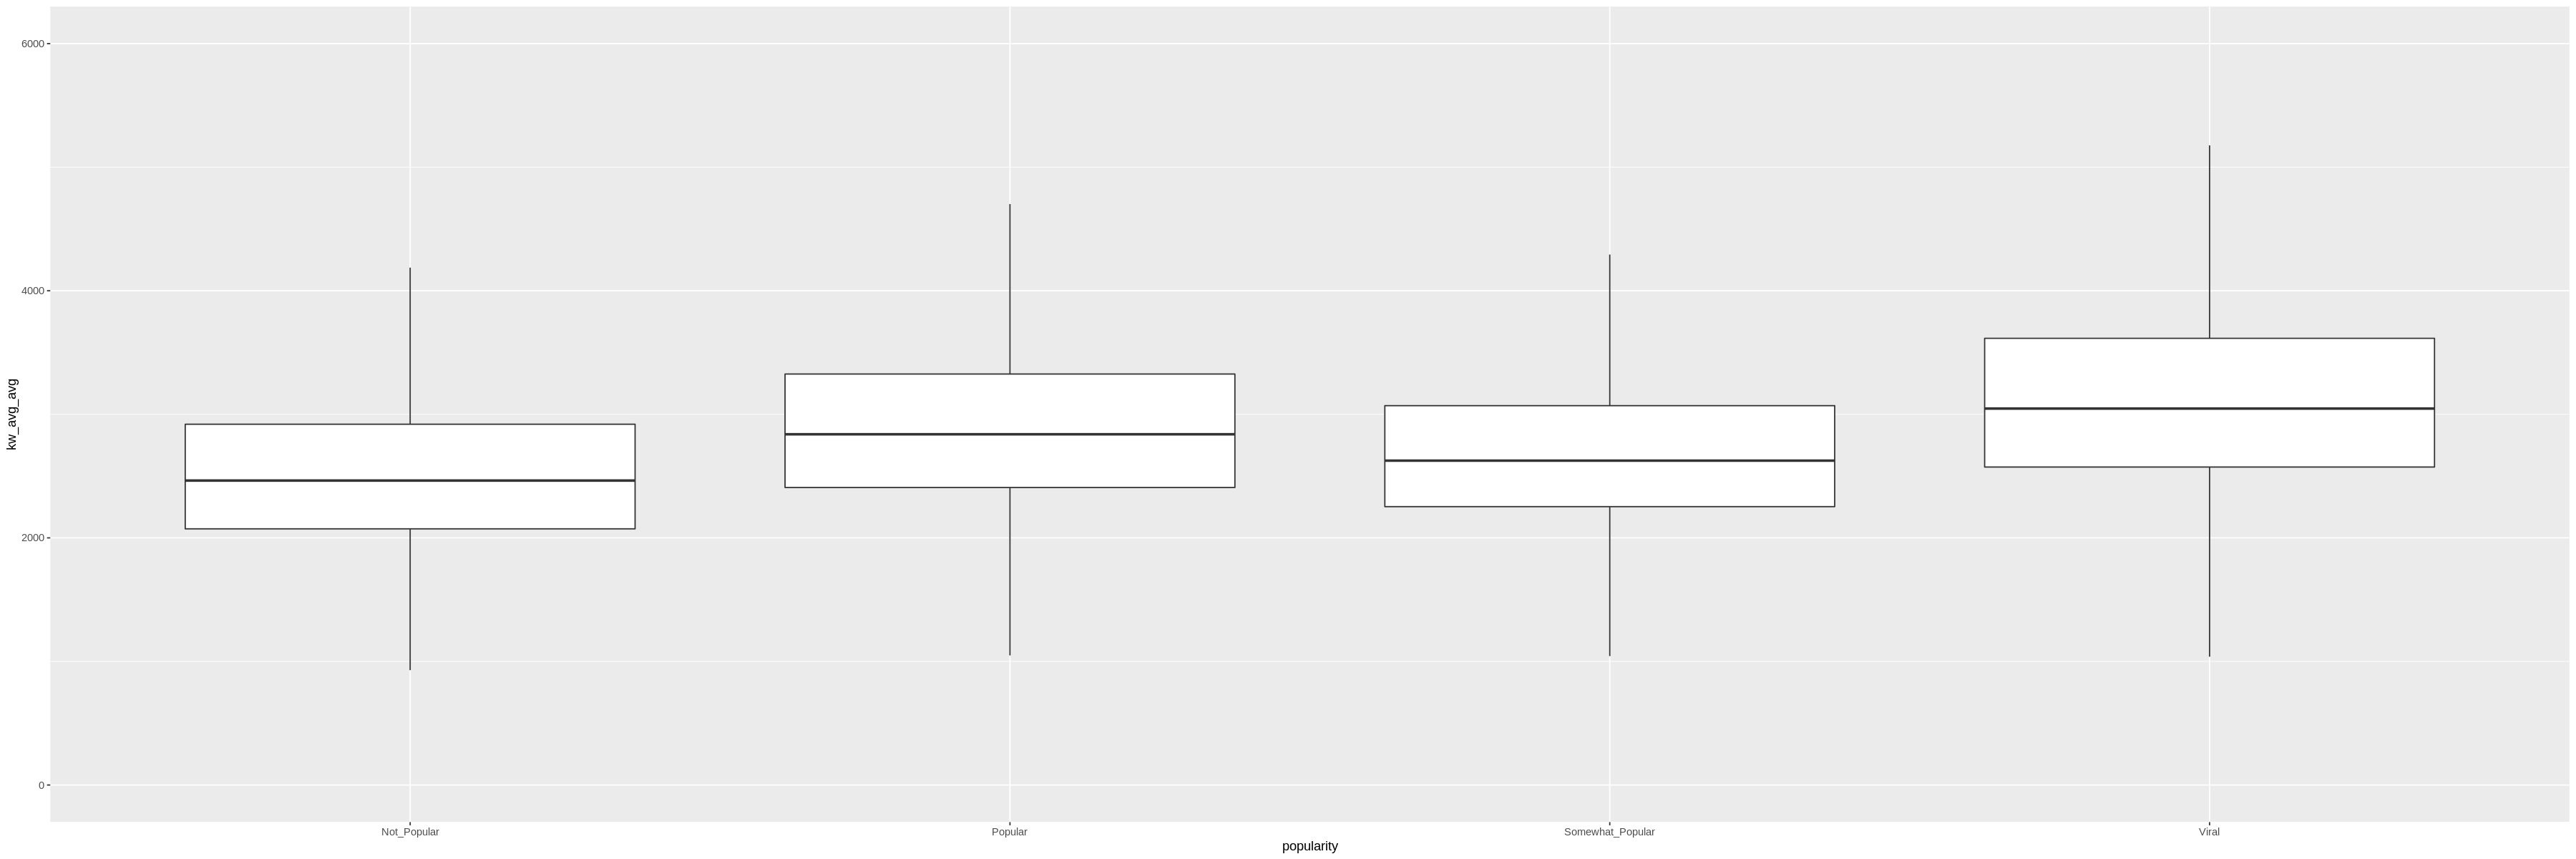

In [22]:
ggplot(tran_predictors, aes(x = popularity, y = kw_avg_avg)) +
geom_boxplot(outlier.shape = NA) +
   ylim(0, 6000)


Warning message:
“Removed 6335 rows containing non-finite values (stat_boxplot).”


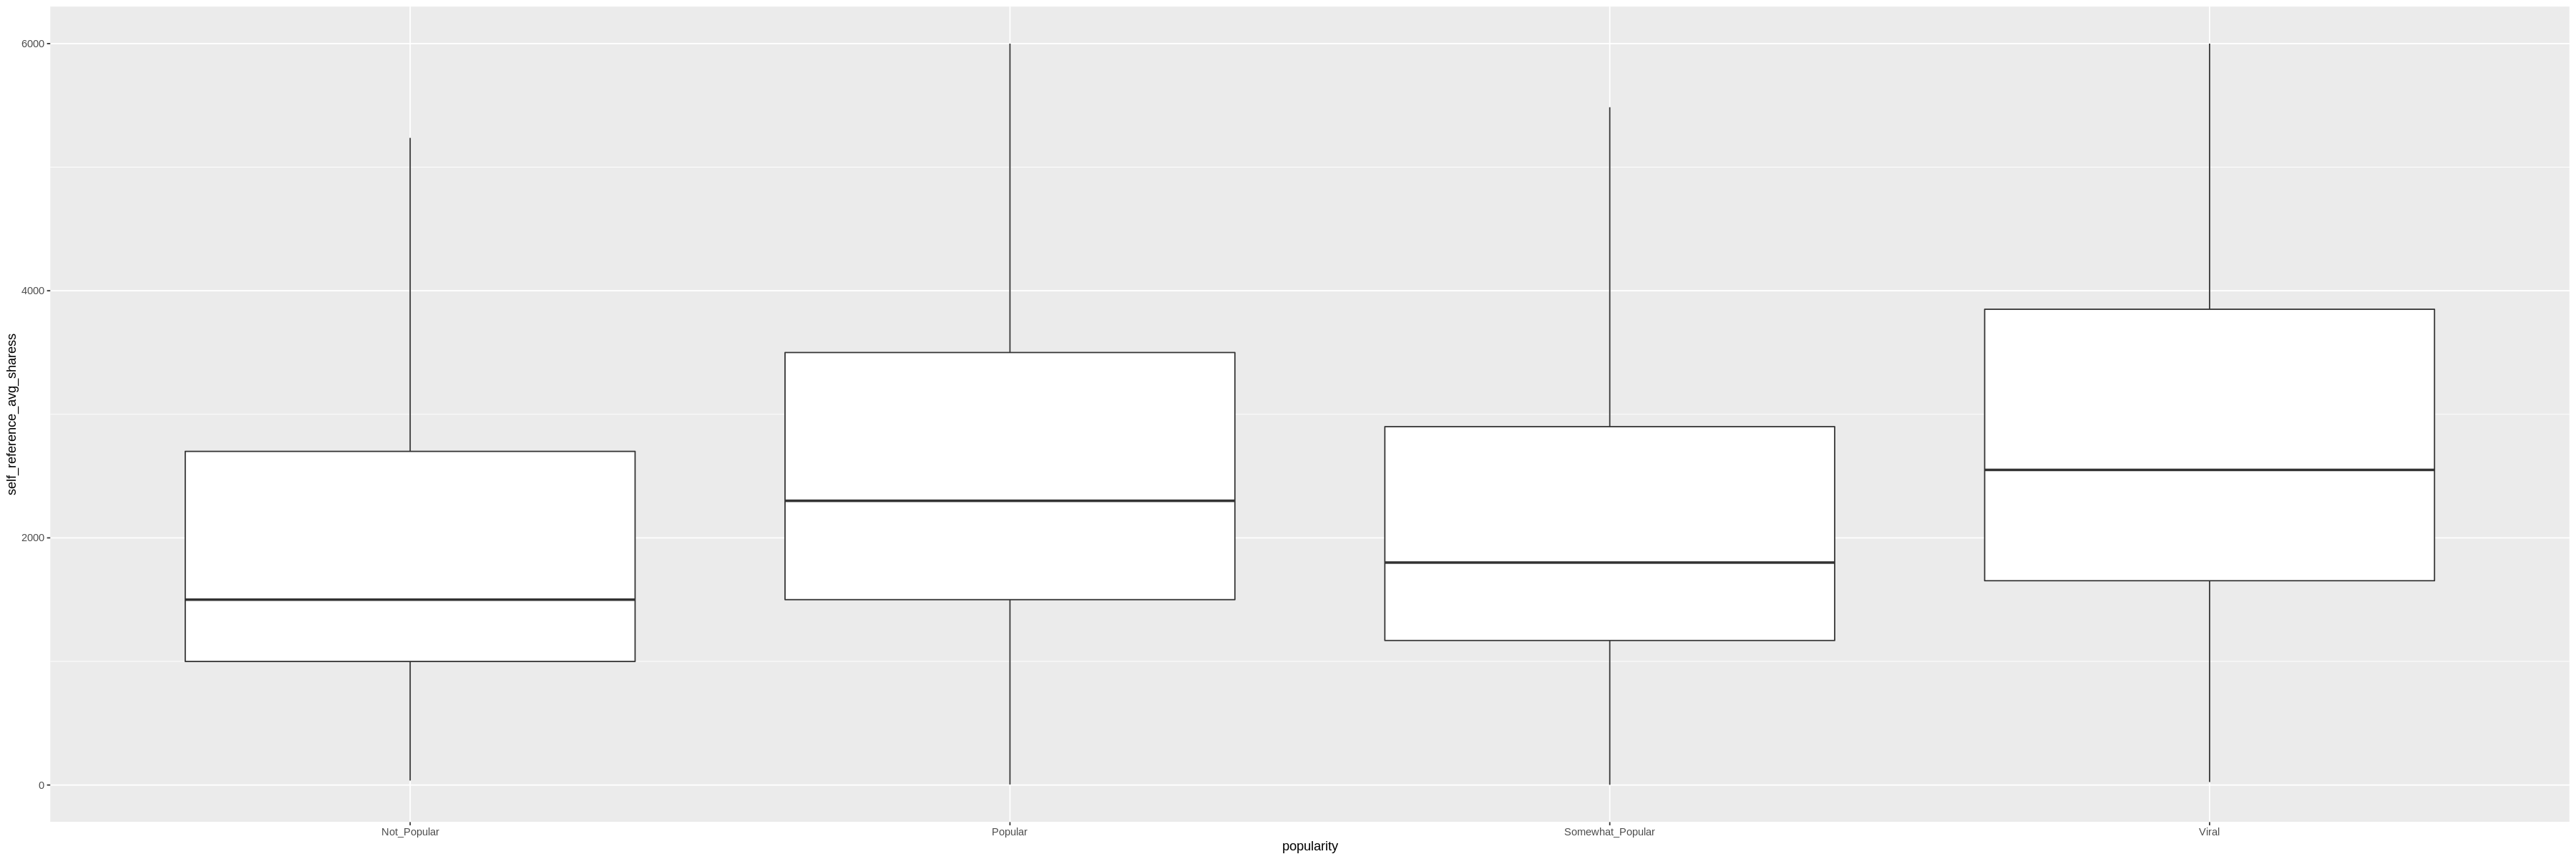

In [23]:
ggplot(tran_predictors, aes(x = popularity, y = self_reference_avg_sharess)) +
geom_boxplot(outlier.shape = NA) +
   ylim(0, 6000)


Warning message:
“Removed 1334 rows containing non-finite values (stat_boxplot).”


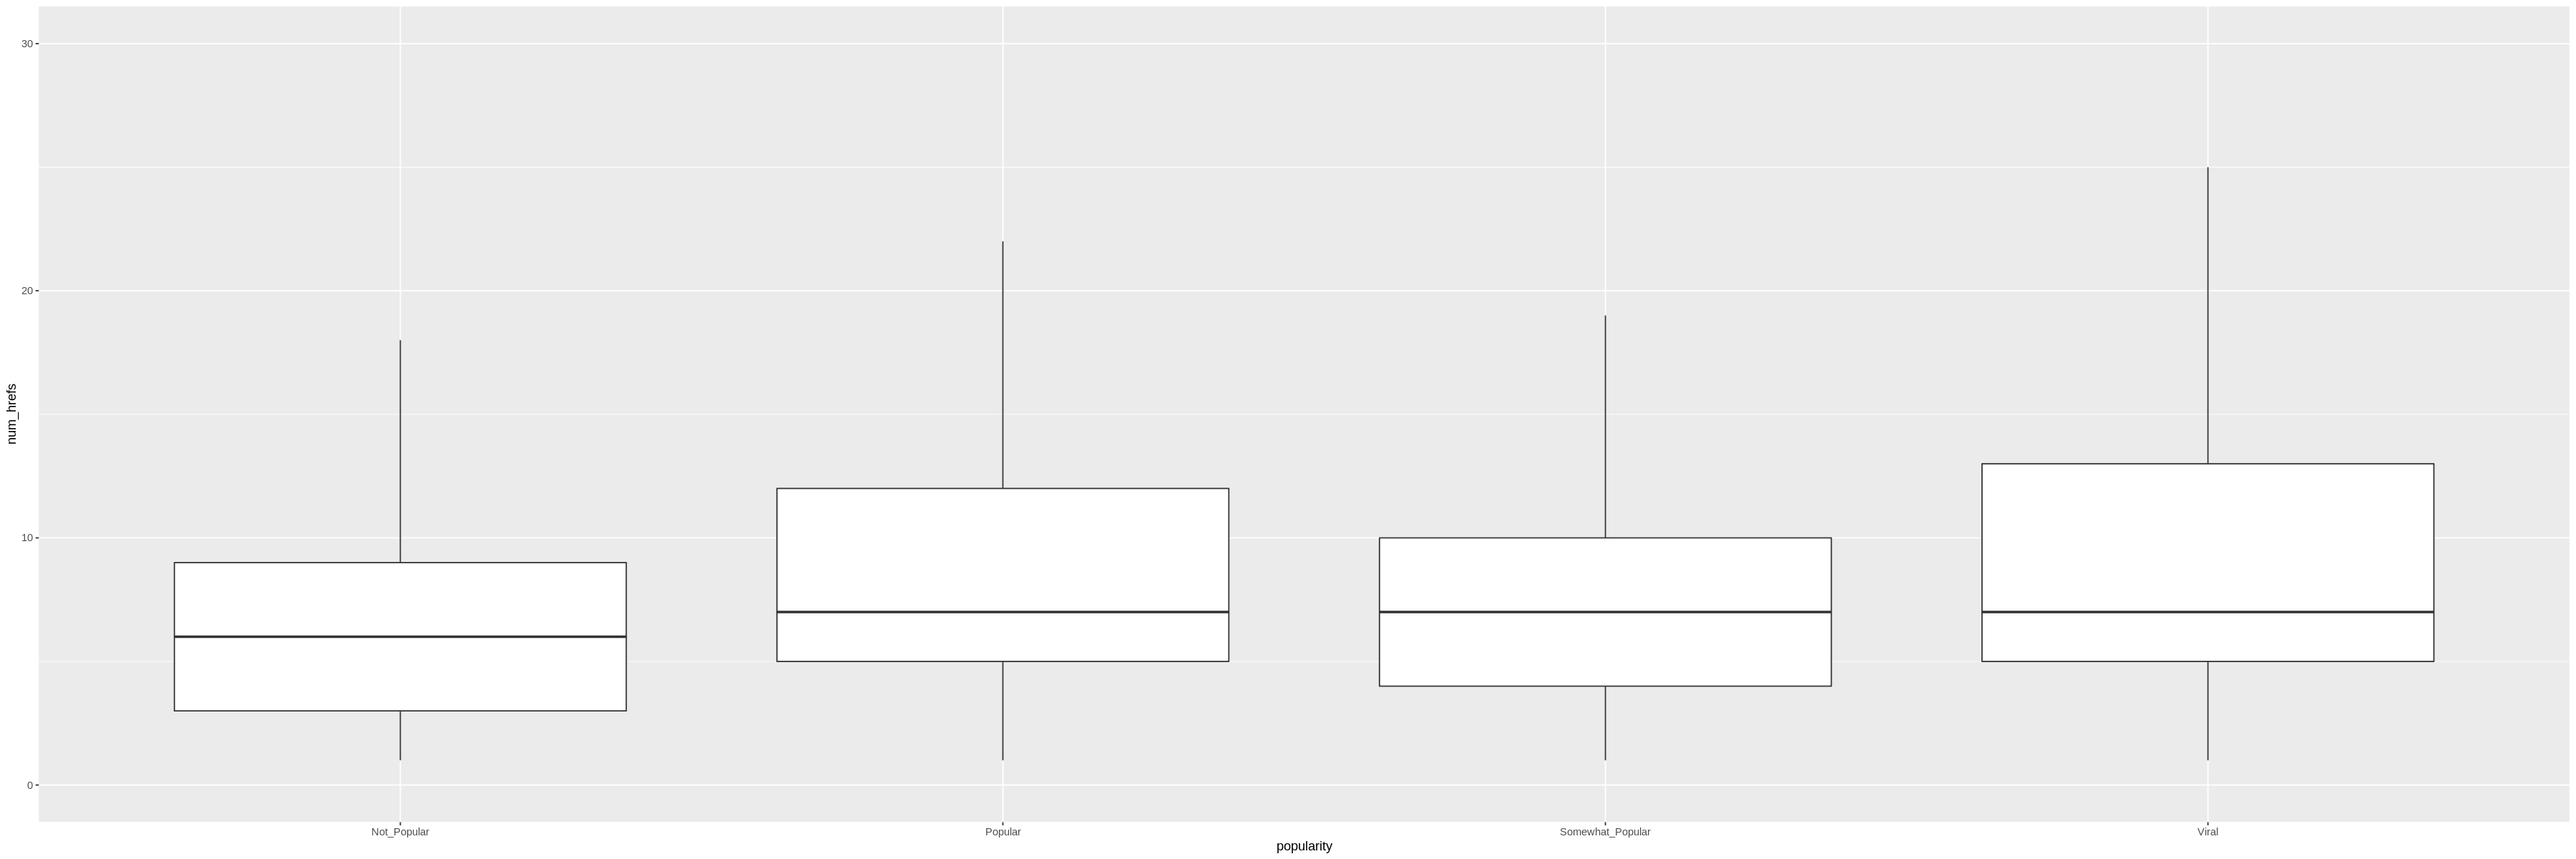

In [24]:
ggplot(tran_predictors, aes(x = popularity, y = num_hrefs)) +
geom_boxplot(outlier.shape = NA) +
   ylim(0, 30)

### KNN regression analysis

In [25]:
## Now we know which predictors we need and what kind of outliers & missing values to remove,
## We retrain our data based on those info
news_processed = news %>% 
                select(kw_avg_avg, self_reference_avg_sharess, num_hrefs, shares) %>% 
                filter(kw_avg_avg != 0) %>% 
                filter(self_reference_avg_sharess != 0) %>% 
                filter(num_hrefs != 0) %>% 
                distinct()
head(news_processed)

kw_avg_avg,self_reference_avg_sharess,num_hrefs,shares
<dbl>,<dbl>,<dbl>,<dbl>
804.3803,3100.000,5,755
1184.5600,727.000,4,4600
1114.0240,951.000,5,1300
884.8520,1300.000,14,1200
1539.4172,3151.158,20,1500
713.9192,20900.000,3,1700


In [26]:
## Re-train our data in a regression manner

splitted_data <- initial_split(news_processed, prop = 0.80, strata = shares)  
train <- training(splitted_data)   
test <- testing(splitted_data)
head(train)
head(test)


kw_avg_avg,self_reference_avg_sharess,num_hrefs,shares
<dbl>,<dbl>,<dbl>,<dbl>
804.3803,3100.000,5,755
1184.5600,727.000,4,4600
1114.0240,951.000,5,1300
1539.4172,3151.158,20,1500
1466.2104,3151.158,21,1200
1645.5334,3151.158,20,500


kw_avg_avg,self_reference_avg_sharess,num_hrefs,shares
<dbl>,<dbl>,<dbl>,<dbl>
884.8520,1300.000,14,1200
713.9192,20900.000,3,1700
1777.3306,3151.158,20,695
1596.9531,3151.158,19,663
1740.7798,2744.375,36,302
1159.5600,3151.158,28,1200


In [38]:
news_knn_recipe = recipe(shares ~ ., data = train)

news_knn_recipe

news_knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
                set_engine("kknn") %>%
                set_mode("regression")

news_knn_spec

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [46]:
news_vfold = vfold_cv(train, v = 5, strata = shares)

news_knn_workflow = workflow() %>% 
                    add_recipe(news_knn_recipe) %>%
                    add_model(news_knn_spec)

news_knn_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [47]:
gridvals = tibble(neighbors = 1:20)

news_knn_results = news_knn_workflow %>% 
                    tune_grid(resamples = news_vfold, grid = gridvals) %>%
                    collect_metrics()

head(news_knn_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,1.128208e+04,5,1.157053e+03,Model01
1,rsq,standard,7.496909e-04,5,3.920145e-04,Model01
2,rmse,standard,9.842252e+03,5,8.555540e+02,Model02
2,rsq,standard,1.298602e-03,5,6.173216e-04,Model02
3,rmse,standard,9.612459e+03,5,8.607029e+02,Model03
3,rsq,standard,1.387084e-03,5,3.079138e-04,Model03


In [41]:
knn_rmspe = news_knn_results %>% 
            filter(.metric == "rmse") %>% 
            select(mean) %>% 
            arrange(mean) %>% 
            slice(1) %>% 
            pull()
            
knn_rmspe

[1] 7895.964

So we get a knn regression with a RMSPE of 10356.13. We will then try to use linear regression to see which one is better

### Linear Regression

In [42]:
lm_spec = linear_reg() %>% 
          set_engine("lm") %>% 
          set_mode("regression")

news_recipe = recipe(shares ~ ., data = train) 

news_lm_fit = workflow() %>% 
        add_recipe(news_recipe) %>% 
        add_model(lm_spec) %>% 
        fit(data = train)

news_lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
               (Intercept)                  kw_avg_avg  
                 45.735798                    0.861918  
self_reference_avg_sharess                   num_hrefs  
                  0.008639                   30.139224  


In [48]:
news_lm_pred = news_lm_fit %>% 
              predict(test) %>% 
              bind_cols(test)
head(news_lm_pred)

news_lm_rmspe =  news_lm_pred %>% 
        metrics(truth = shares, estimate = .pred) %>% 
        filter(.metric == "rmse") %>% 
        select(.estimate) %>% 
        pull()
news_lm_rmspe

.pred,kw_avg_avg,self_reference_avg_sharess,num_hrefs,shares
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1241.5858,884.8520,1300.000,14,1200
932.0478,713.9192,20900.000,3,1700
2207.6570,1777.3306,3151.158,20,695
2022.0471,1596.9531,3151.158,19,663
2654.8666,1740.7798,2744.375,36,302
1916.3029,1159.5600,3151.158,28,1200


[1] 15283.84

### Compare KNN and linear regression

In [44]:
if(knn_rmspe < news_lm_rmspe){
  print("We use knn-regresion as it has a smaller RMSPE")
} else{
  print("we use simple linear regression as it has a smaller RMSPE")
}
knn_rmspe
news_lm_rmspe

[1] "We use knn-regresion as it has a smaller RMSPE"


[1] 7895.964

[1] 15283.84

### Visualization of our prediction

In [61]:
lmplot <- lm(shares ~ ., data = news_processed)
summary(lmplot)

## https://rpubs.com/bensonsyd/385183


Call:
lm(formula = shares ~ ., data = news_processed)

Residuals:
   Min     1Q Median     3Q    Max 
-31266  -1848  -1266   -287 685479 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.298e+02  1.741e+02   0.746    0.456    
kw_avg_avg                 8.181e-01  5.450e-02  15.012  < 2e-16 ***
self_reference_avg_sharess 1.855e-02  2.364e-03   7.848 4.37e-15 ***
num_hrefs                  3.163e+01  5.447e+00   5.807 6.44e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10040 on 27368 degrees of freedom
Multiple R-squared:  0.01387,	Adjusted R-squared:  0.01376 
F-statistic: 128.3 on 3 and 27368 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula 'y ~ x'



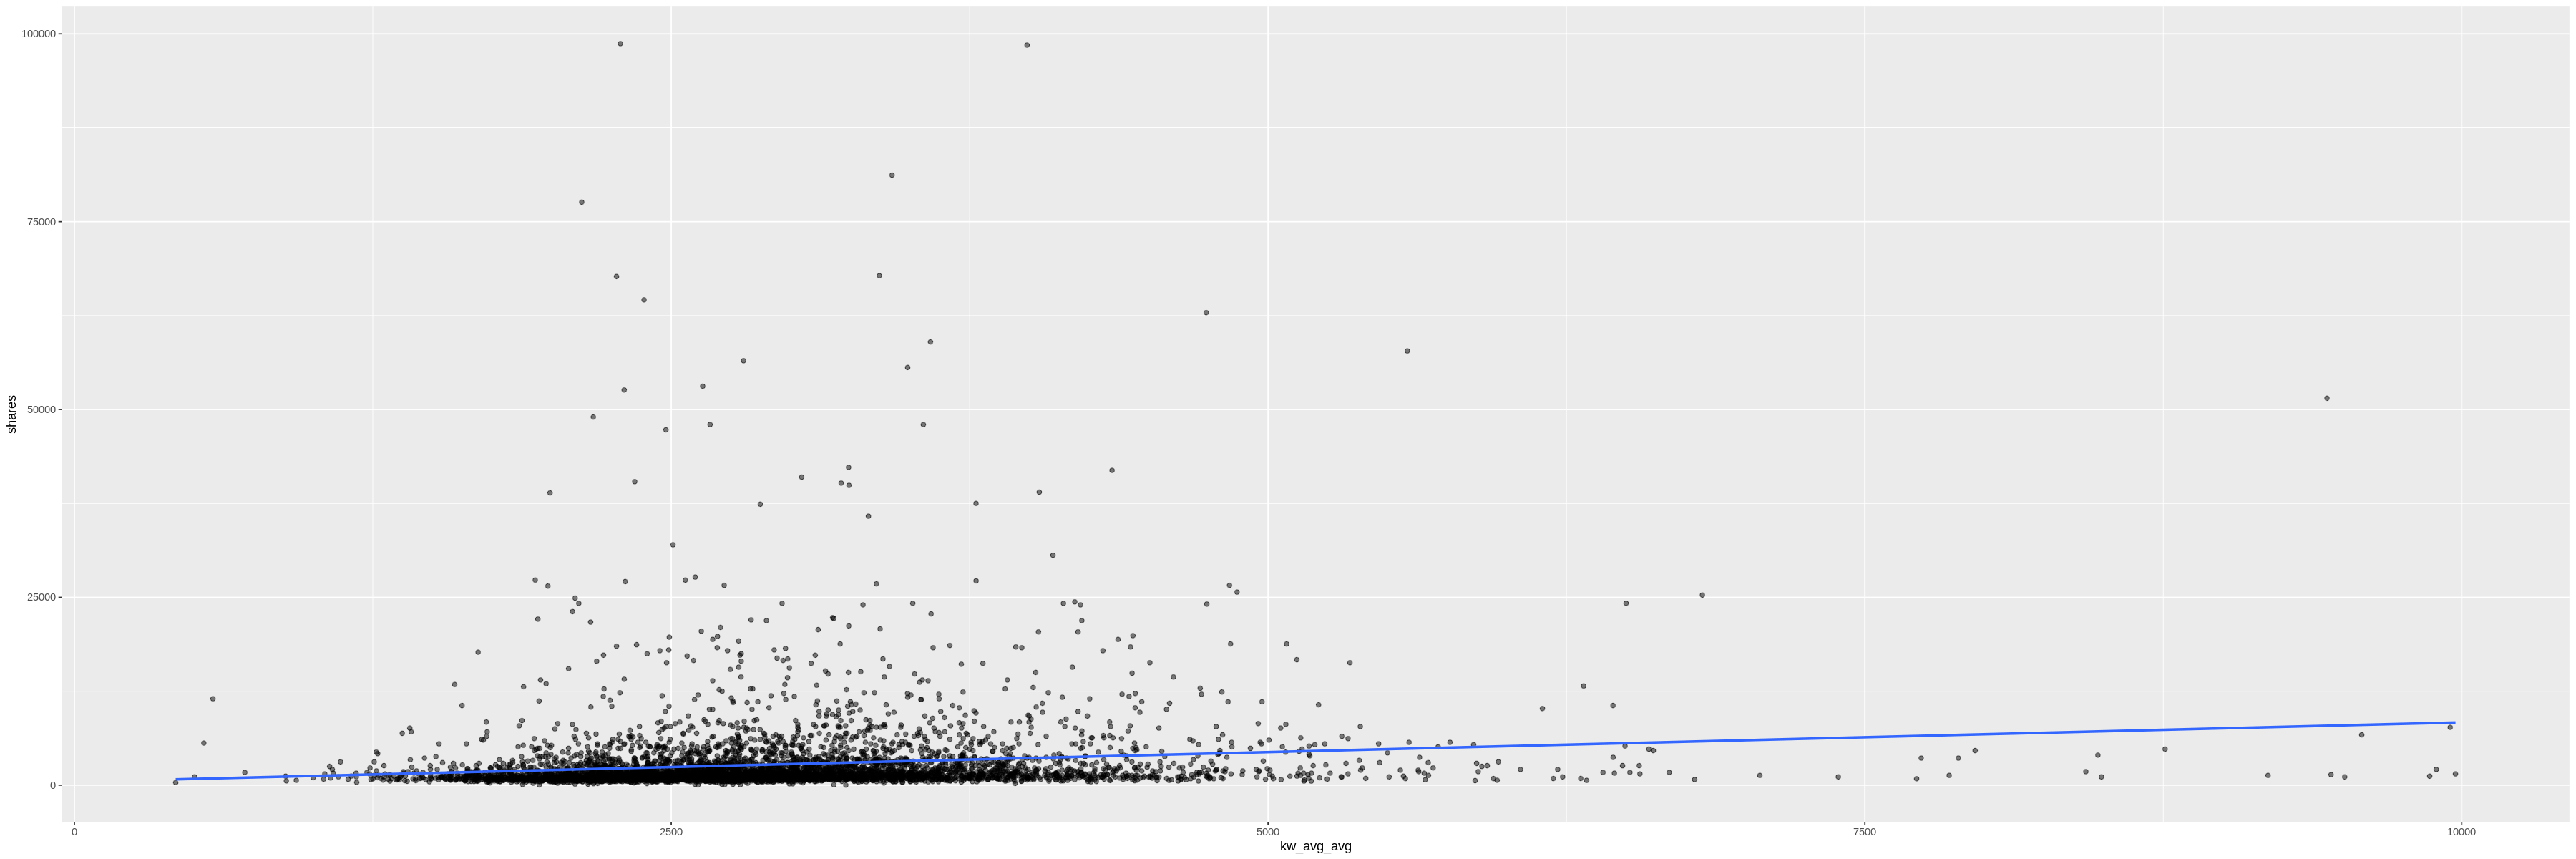

In [76]:
## due to the outliers of the data, we will zoom into a portion using filters.
## To see the original unzoomed plots, uncomment the code below

# lm_kw = news_lm_pred %>% 
#         ggplot(aes(x = kw_avg_avg, y = shares)) +
#         geom_point(alpha = 0.5) + 
#         geom_smooth(method = "lm", se = FALSE) +
#         labs(x = "Averge Keyword")
# lm_kw
        
lm_kw_zm = news_lm_pred %>% 
        filter(kw_avg_avg < 10000) %>% 
        filter(shares < 1e+05) %>% 
        ggplot(aes(x = kw_avg_avg, y = shares)) +
        geom_point(alpha = 0.5) + 
        geom_smooth(method = "lm", se = FALSE)
lm_kw_zm


`geom_smooth()` using formula 'y ~ x'



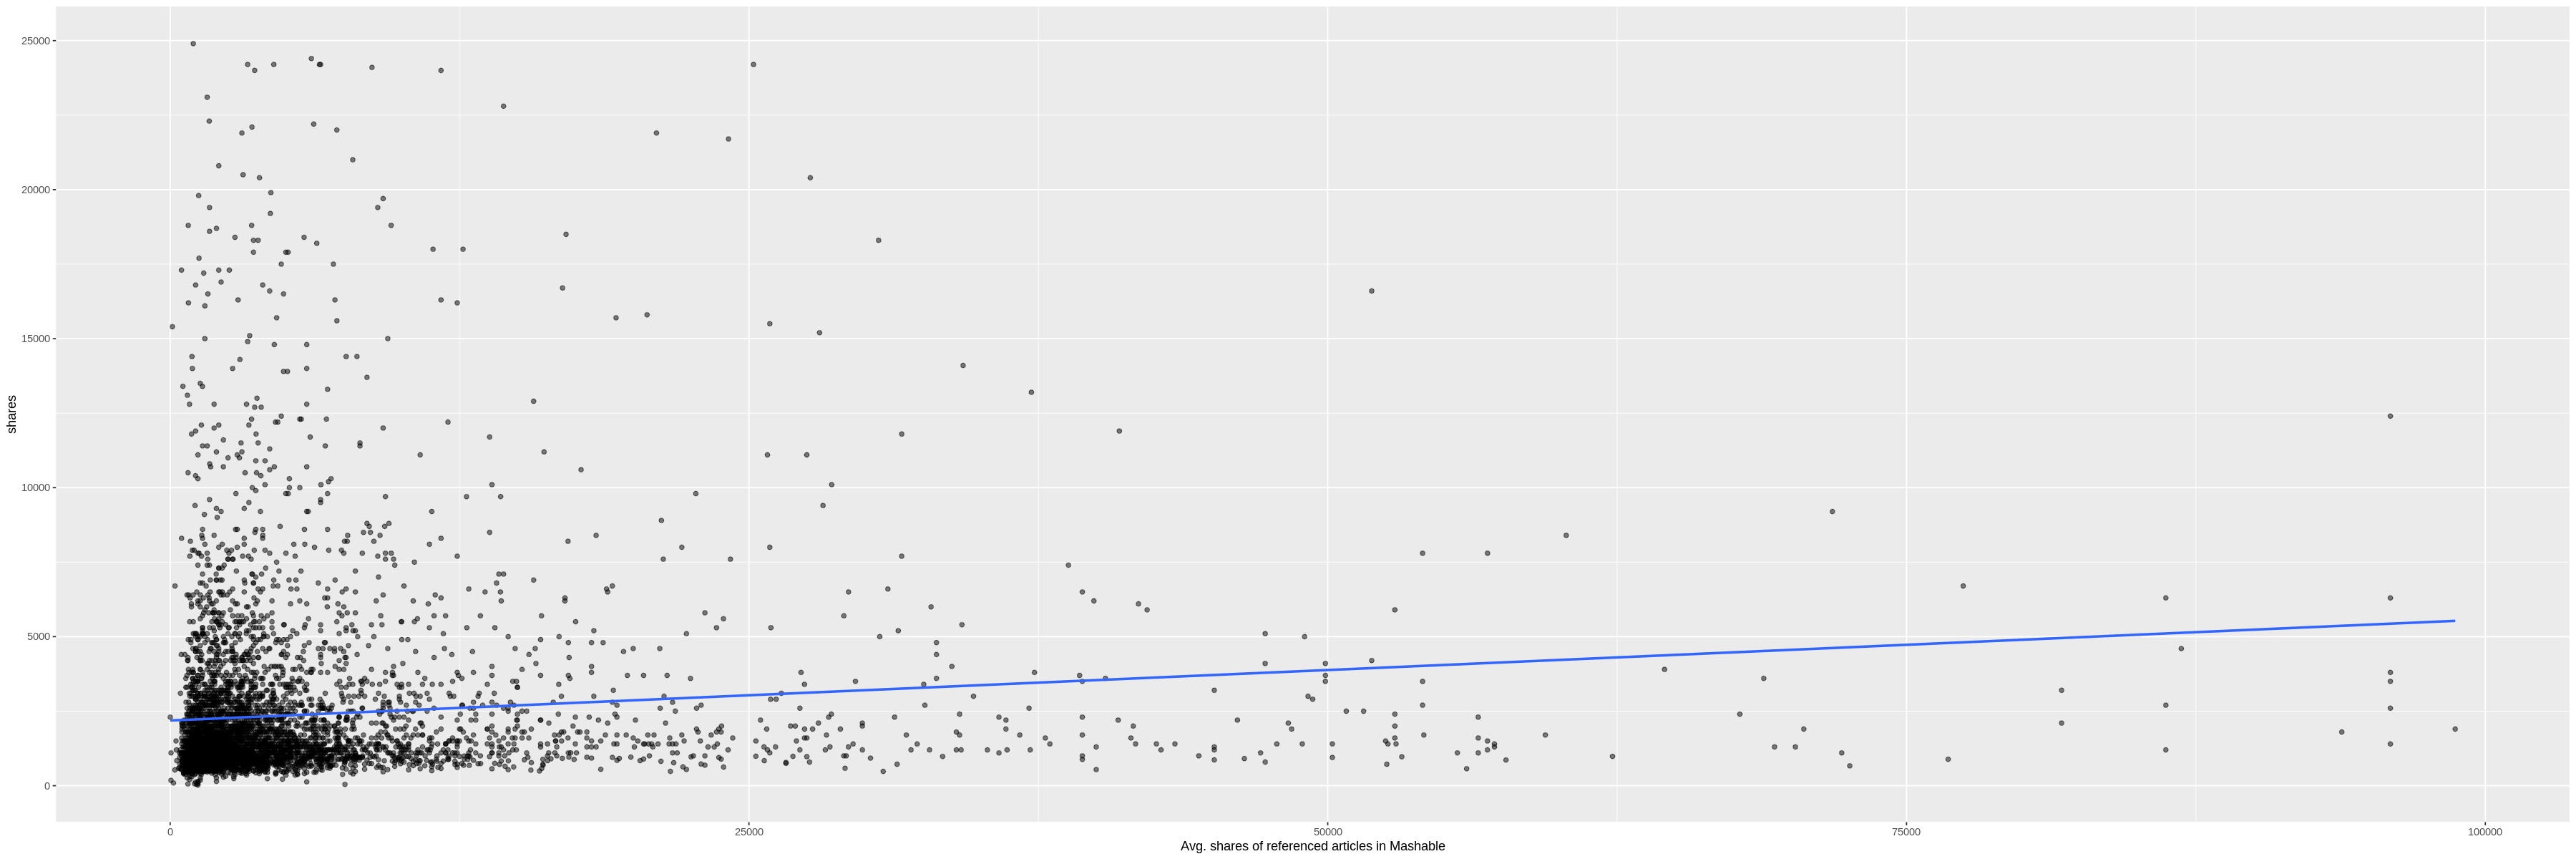

In [77]:
## due to the outliers of the data, we will zoom into a portion using filters.
## To see the original unzoomed plots, uncomment the code below

# lm_self_ref = news_lm_pred %>% 
#         ggplot(aes(x = self_reference_avg_sharess, y = shares)) +
#         geom_point(alpha = 0.5) + 
#         geom_smooth(method = "lm", se = FALSE) +
#         labs(x = "Avg. shares of referenced articles in Mashable")
# lm_self_ref
        

lm_self_ref_zm = news_lm_pred %>% 
        filter(self_reference_avg_sharess < 1e+05) %>% 
        filter(shares < 25000) %>% 
        ggplot(aes(x = self_reference_avg_sharess, y = shares)) +
        labs(x = "Avg. shares of referenced articles in Mashable") +
        geom_point(alpha = 0.5) + 
        geom_smooth(method = "lm", se = FALSE)
lm_self_ref_zm


`geom_smooth()` using formula 'y ~ x'



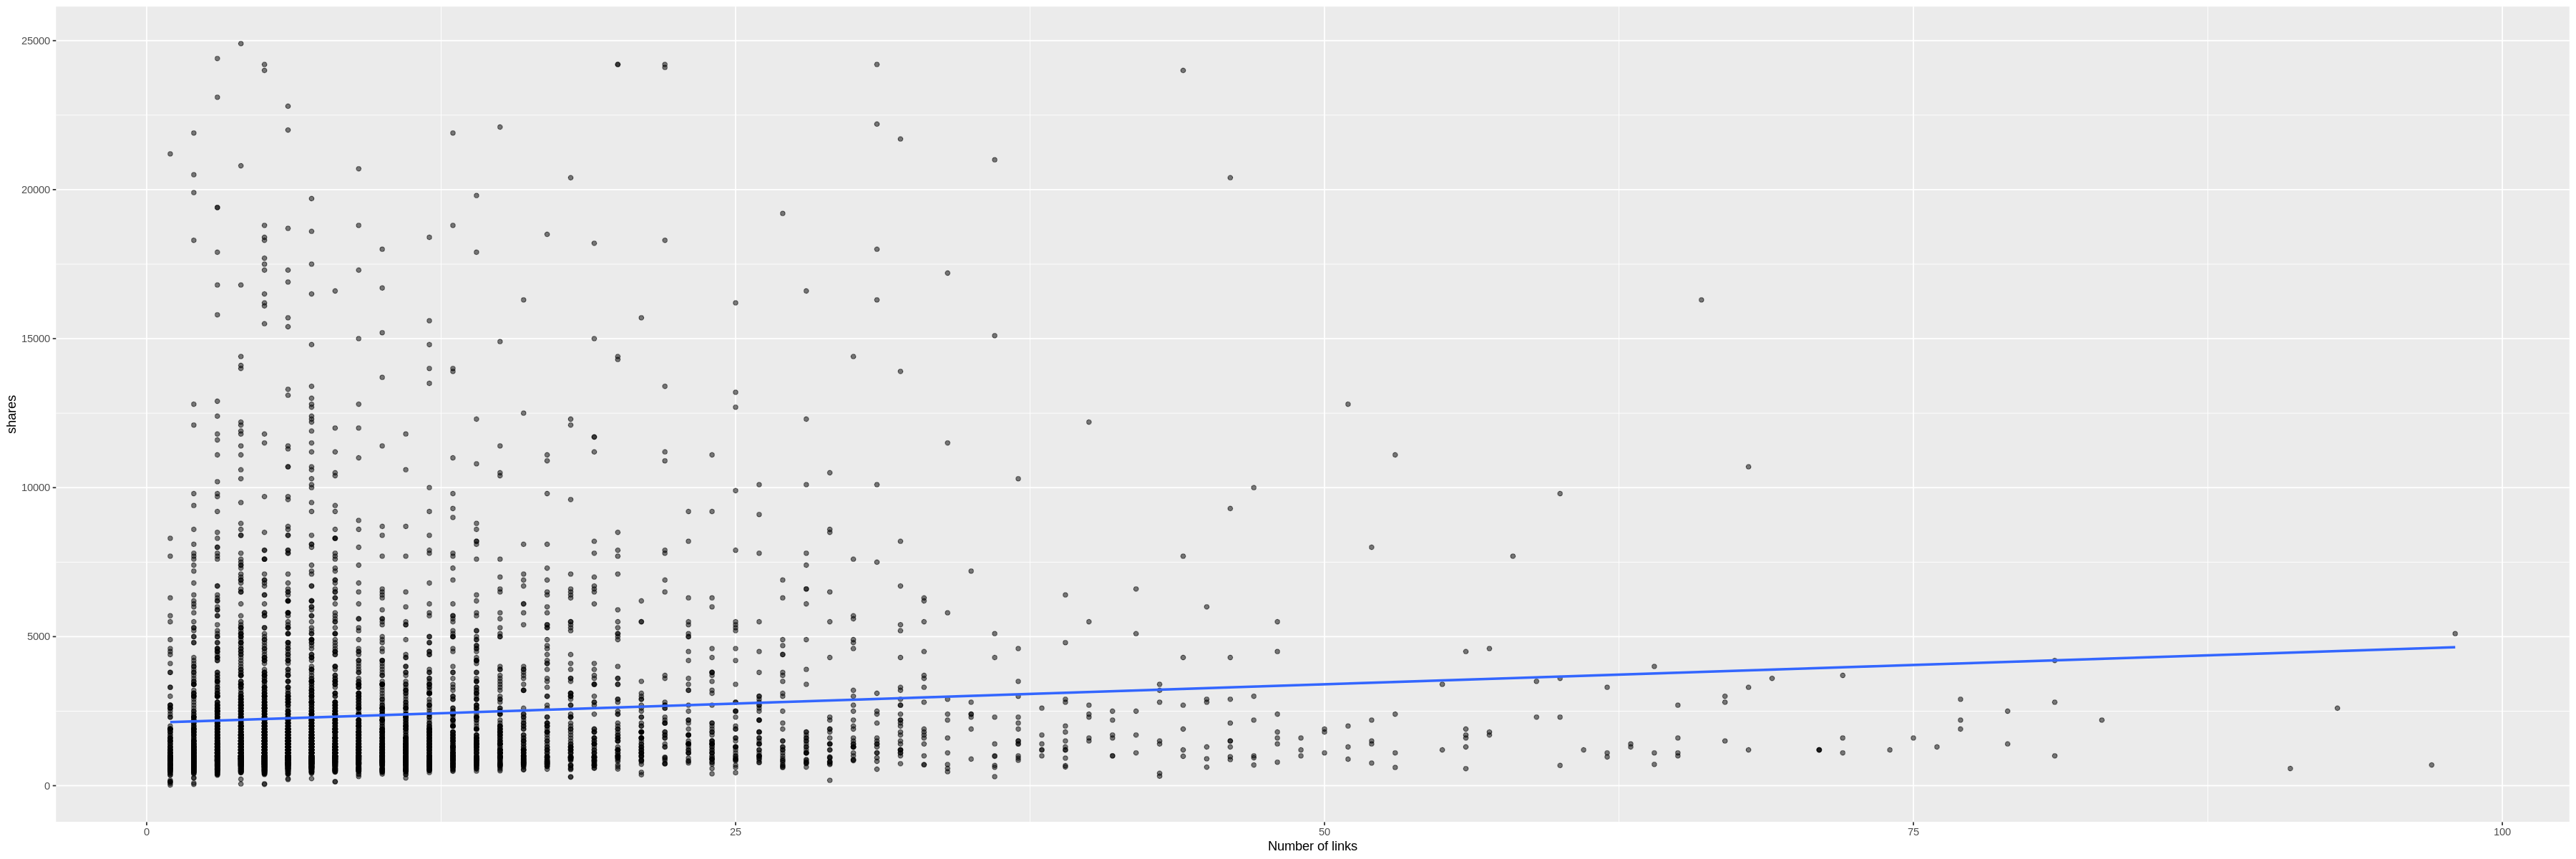

In [78]:
## due to the outliers of the data, we will zoom into a portion using filters.
## To see the original unzoomed plots, uncomment the code below

# lm_num_hrefs = news_lm_pred %>% 
#         ggplot(aes(x = num_hrefs, y = shares)) +
#         geom_point(alpha = 0.5) + 
#         geom_smooth(method = "lm", se = FALSE) +
#         labs(x = "Number of links")
# lm_num_hrefs
        

lm_num_hrefs_zm = news_lm_pred %>% 
        filter(num_hrefs < 100) %>% 
        filter(shares < 0.25e+05) %>% 
        ggplot(aes(x = num_hrefs, y = shares)) +
        labs(x = "Number of links") +
        geom_point(alpha = 0.5) + 
        geom_smooth(method = "lm", se = FALSE)
lm_num_hrefs_zm

### Discussion

* Our guess is that the prediction will not work very well as the correlation between our predictors and the response variable shares are extremely low: the highest of the three is around 0.1. Therefore, we are not suprised that ...
* Regardless of our accuracy in predicting the popularity of a facebook share given some attributes of the post, some people is going to be crazy about it. Popular posts ~> influencers or even internet celebrities ~> tons of money ~> no matter how unreliable the methods are and how mere the chances are, they will give it a try. 
* Future questions: Are there any correlations among the predictors themselves? If individually, the predictors have a low correlation with the response variable, how about all together? Or some of them together? 

* From the predictors we have chosen, we found that the our correlations were 0.1, 0.06, 0.04. Based on our training set, we found that. RMPSE was ... which suggest the accuracy of our model. 
* Our guess is that the prediction will not work very well as the correlation between our predictors and the response variable shares are extremely low: the highest of the three is around 0.1. Therefore, we are not suprised that ...
* Regardless of our accuracy in predicting the popularity of a facebook share given some attributes of the post, some people is going to be crazy about it. Popular posts ~> influencers or even internet celebrities ~> tons of money ~> no matter how unreliable the methods are and how mere the chances are, they will give it a try. 
* Future questions: Are there any correlations among the predictors themselves? If individually, the predictors have a low correlation with the response variable, how about all together? Or some of them together? 

#### Methods

Like we mentioned in the preliminary exploratory, we cleaned the data 17 columns out of 61, which are about shared numbers, when the articles were published (Monday to Sunday), category of the articles (Lifestyle, Entertainment etc.), rate of unique words, average length, and both best and worst keywords. Those columns were thought to be connected with a shared number. Also, using the 4 categories about popularity we defined above, we separate the data and cut out outliers, and we use box plots and histogram to visualize.

#### Expected outcomes and significance

We expect to find some kind of relationship between the columns of the dataset and the popularity. Also, considering the amount of columns we already have in the dataset, it would not be a surprise if the relationship is not easily visible to human visualization. Such a relationship will however be examined on how well it can predict the popularity of a new observation. Such findings can help us understand what are some properties of news articles that make them popular. It can lead to further questions such as which column have more profound impact on popularity? Or do the columns responsible for popularity different for different types of topics?